In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# === Cell 1: Install Libraries ===
!pip install scanpy scvi-tools anndata matplotlib pandas leidenalg --quiet

print("Libraries installed/updated.")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.2/503.2 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.8/365.8 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━

In [51]:
# === Cell 2: Import Libraries ===
import scanpy as sc
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys # For sys.exit

print(f"Scanpy version: {sc.__version__}")
print(f"Anndata version: {ad.__version__}")

Scanpy version: 1.11.1
Anndata version: 0.11.4


In [54]:
# === Cell 3: Define Parameters and File Paths ===

# !!! IMPORTANT: SET THIS PATH !!!

# Option A: If uploaded directly to Colab session storage (temporary)
# input_adata_path = "adata_scvi_trained.h5ad"

# Option B: If using Google Drive (recommended)
from google.colab import drive
drive.mount('/content/drive')
input_adata_path = "/content/drive/MyDrive/raw/adata_scvi_trained.h5ad" # <<< EDIT THIS LINE

# --- Parameters for Neighbors and Clustering ---
n_neighbors_param = 30 # Number of neighbors (Tune this: e.g., 15, 30, 50)

# --- List of Leiden resolution parameters to experiment with ---
# <<< SET RESOLUTIONS TO TRY HERE >>>
resolutions_to_try = [0.4, 0.6, 0.8, 1.0, 1.2, 1.5]

# --- Metadata columns to visualize alongside clusterings ---
# <<< EDIT THIS LIST based on your adata.obs columns >>>
metadata_keys_to_plot = [
    'ethnicity',
    'infection_status',
    'cell_subtype' # Add/remove columns present in your AnnData
]

# --- Print parameters for confirmation ---
print("--- Parameters Set ---")
print(f"Input AnnData Path: {input_adata_path}")
print(f"Neighbors (n_neighbors): {n_neighbors_param}")
print(f"Leiden Resolutions to try: {resolutions_to_try}")
print(f"Metadata keys to plot: {metadata_keys_to_plot}")
print("----------------------")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Parameters Set ---
Input AnnData Path: /content/drive/MyDrive/raw/adata_scvi_trained.h5ad
Neighbors (n_neighbors): 30
Leiden Resolutions to try: [0.4, 0.6, 0.8, 1.0, 1.2, 1.5]
Metadata keys to plot: ['ethnicity', 'infection_status', 'cell_subtype']
----------------------


In [55]:
# === Cell 4: Load AnnData Object ===
print(f"\n--- Loading AnnData object from: {input_adata_path} ---")

# Check if the file exists before attempting to load
if not os.path.exists(input_adata_path):
  print(f"ERROR: Input file not found at '{input_adata_path}'")
  print("Please ensure the file exists and the path is correct in Cell 3.")
  print("If using Google Drive, make sure it's mounted (run Cell 3 again if needed) and the path starts with /content/drive/MyDrive/...")
  # Stop execution if file not found (optional, prevents further errors)
  # To stop, uncomment the next line:
  # raise FileNotFoundError(f"Input file not found: {input_adata_path}")
else:
    try:
      adata = sc.read_h5ad(input_adata_path)
      print(f"Successfully loaded AnnData object with shape: {adata.shape}")

      # Check if the essential scVI embedding exists
      if 'X_scVI' not in adata.obsm:
          print("\nERROR: 'X_scVI' embedding not found in adata.obsm.")
          print("Please ensure the input AnnData file was generated correctly by the scVI training script.")
          # Stop execution if embedding missing (optional)
          # To stop, uncomment the next line:
          # raise KeyError("Required embedding 'X_scVI' not found in adata.obsm")
      else:
          print("'X_scVI' embedding found.")

    except Exception as e:
      print(f"\nERROR: Failed to load AnnData file: {e}")
      # Stop execution on load error (optional)
      # To stop, uncomment the next line:
      # raise e


--- Loading AnnData object from: /content/drive/MyDrive/raw/adata_scvi_trained.h5ad ---
Successfully loaded AnnData object with shape: (380832, 10000)
'X_scVI' embedding found.


In [56]:
# === Cell 5: Compute Neighbors on scVI Latent Space ===

# Check if adata was loaded successfully before proceeding
if 'adata' in locals():
    print(f"\n--- Computing nearest neighbors using 'X_scVI' (n_neighbors={n_neighbors_param}) ---")
    sc.pp.neighbors(adata, use_rep='X_scVI', n_neighbors=n_neighbors_param)
    print("Neighbor graph computed.")
else:
    print("\nSkipping neighbor computation because AnnData object ('adata') was not loaded successfully.")


--- Computing nearest neighbors using 'X_scVI' (n_neighbors=30) ---
Neighbor graph computed.


In [57]:
# === Cell 6: Perform Clustering (Leiden) ===

cluster_keys_generated = [] # Keep track of the new cluster columns

# Check if adata and neighbors exist before proceeding
if 'adata' in locals() and 'neighbors' in adata.uns:
    print(f"\n--- Running Leiden clustering for resolutions: {resolutions_to_try} ---")
    for res in resolutions_to_try:
      key_added = f'leiden_scvi_res{res}'
      print(f"   Running Leiden with resolution={res} -> key='{key_added}'")
      sc.tl.leiden(adata, resolution=res, key_added=key_added)
      cluster_keys_generated.append(key_added)
      # Display value counts for the new cluster column (optional)
      # print(adata.obs[key_added].value_counts())

    print("\nLeiden clustering complete for all resolutions.")
    print(f"Generated cluster keys: {cluster_keys_generated}")
else:
    print("\nSkipping Leiden clustering because AnnData object ('adata') or neighbor graph is missing.")


--- Running Leiden clustering for resolutions: [0.4, 0.6, 0.8, 1.0, 1.2, 1.5] ---
   Running Leiden with resolution=0.4 -> key='leiden_scvi_res0.4'
   Running Leiden with resolution=0.6 -> key='leiden_scvi_res0.6'
   Running Leiden with resolution=0.8 -> key='leiden_scvi_res0.8'
   Running Leiden with resolution=1.0 -> key='leiden_scvi_res1.0'
   Running Leiden with resolution=1.2 -> key='leiden_scvi_res1.2'
   Running Leiden with resolution=1.5 -> key='leiden_scvi_res1.5'

Leiden clustering complete for all resolutions.
Generated cluster keys: ['leiden_scvi_res0.4', 'leiden_scvi_res0.6', 'leiden_scvi_res0.8', 'leiden_scvi_res1.0', 'leiden_scvi_res1.2', 'leiden_scvi_res1.5']


In [58]:
# === Cell 7: Compute UMAP ===

# Check if adata and neighbors exist before proceeding
if 'adata' in locals() and 'neighbors' in adata.uns:
    print("\n--- Computing UMAP ---")
    # UMAP uses the neighbor graph computed in step 5
    # You can experiment with min_dist and spread for visualization aesthetics
    sc.tl.umap(adata, min_dist=0.3, spread=1.0)
    print("UMAP coordinates computed and stored in adata.obsm['X_umap']")
else:
    print("\nSkipping UMAP computation because AnnData object ('adata') or neighbor graph is missing.")


--- Computing UMAP ---
UMAP coordinates computed and stored in adata.obsm['X_umap']



--- Generating UMAP Plots ---
Plotting UMAPs colored by: leiden_scvi_res0.4, leiden_scvi_res0.6, leiden_scvi_res0.8, leiden_scvi_res1.0, leiden_scvi_res1.2, leiden_scvi_res1.5, ethnicity, infection_status, cell_subtype
   Generating plot for leiden_scvi_res0.4...


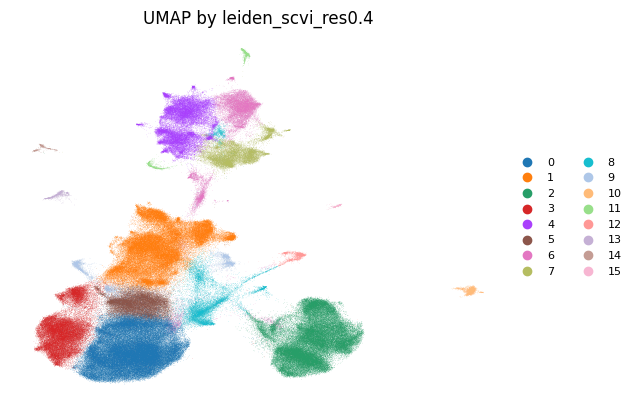

   Generating plot for leiden_scvi_res0.6...


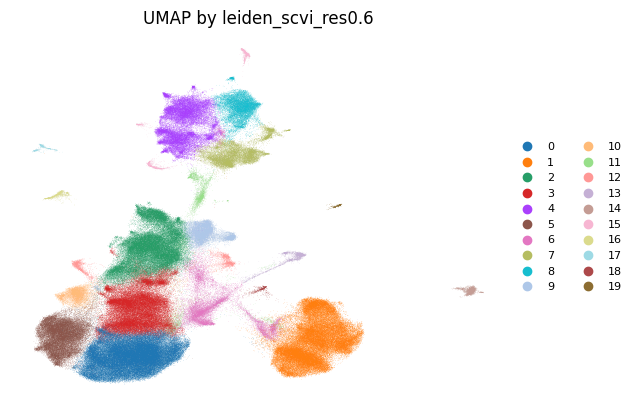

   Generating plot for leiden_scvi_res0.8...


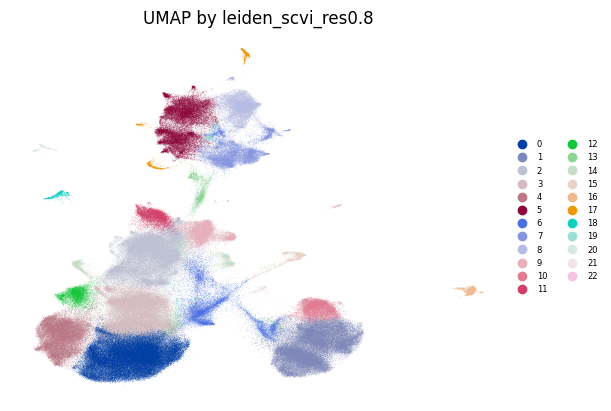

   Generating plot for leiden_scvi_res1.0...


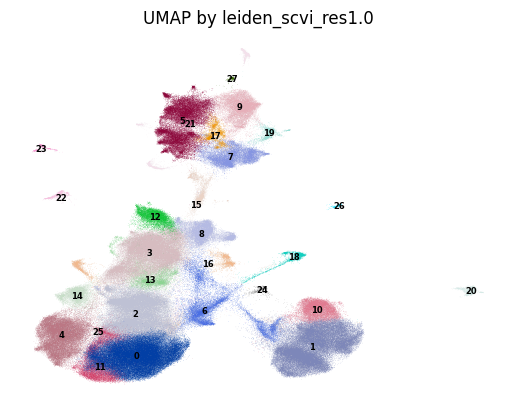

   Generating plot for leiden_scvi_res1.2...


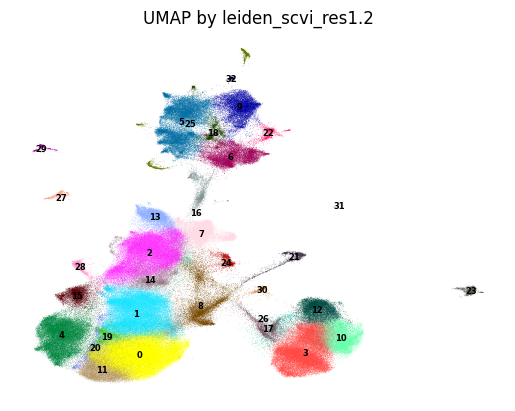

   Generating plot for leiden_scvi_res1.5...


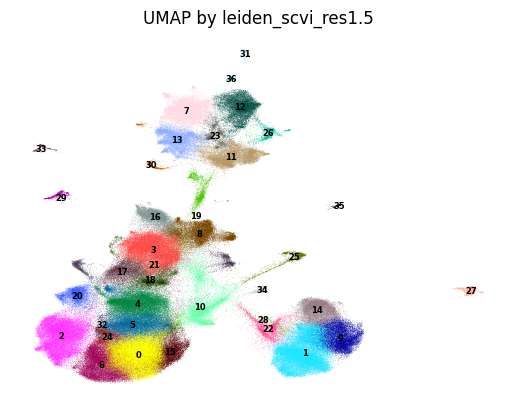

   Generating plot for ethnicity...


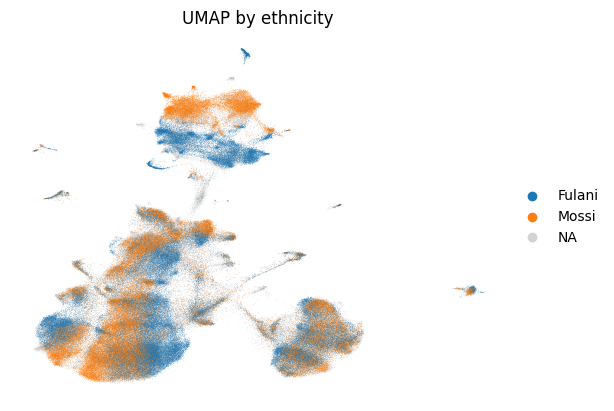

   Generating plot for infection_status...


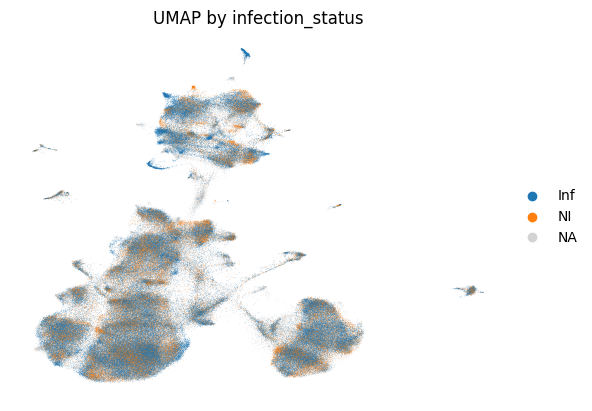

   Generating plot for cell_subtype...


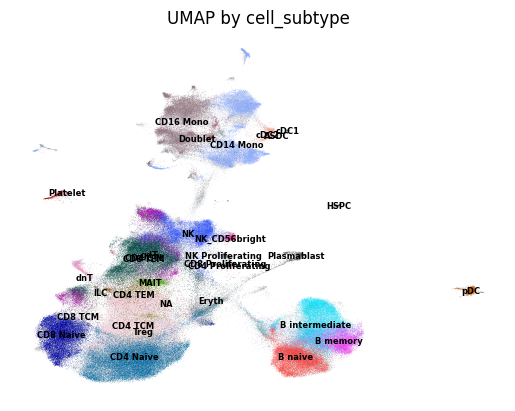


--- UMAP Plotting Finished ---


In [59]:
# === Cell 8: Visualize Results ===

# Check if adata and UMAP coordinates exist before proceeding
if 'adata' in locals() and 'X_umap' in adata.obsm:
    print("\n--- Generating UMAP Plots ---")

    # Combine generated cluster keys and specified metadata keys for plotting
    valid_metadata_keys = [k for k in metadata_keys_to_plot if k in adata.obs.columns]
    if len(valid_metadata_keys) < len(metadata_keys_to_plot):
        print(f"Warning: Some specified metadata keys not found in adata.obs. Plotting only: {valid_metadata_keys}")

    all_keys_to_plot = cluster_keys_generated + valid_metadata_keys

    print(f"Plotting UMAPs colored by: {', '.join(all_keys_to_plot)}")
    # Increase figure width if many plots (optional)
    # plt.rcParams['figure.figsize'] = (7, 7) # Uncomment and adjust if needed

    for color_key in all_keys_to_plot:
        title = f"UMAP by {color_key}"
        print(f"   Generating plot for {color_key}...")
        try:
            # Adjust legend location and font size dynamically based on number of categories
            num_categories = adata.obs[color_key].nunique()
            legend_loc = 'on data' if num_categories > 25 else 'right margin'
            legend_fontsize = 6 if num_categories > 20 else (8 if num_categories > 10 else 10)

            sc.pl.umap(
                adata,
                color=color_key,
                title=title,
                frameon=False,
                show=True, # Show plot immediately in Colab
                legend_loc=legend_loc,
                legend_fontsize=legend_fontsize
            )
        except KeyError:
            print(f"     Warning: Column '{color_key}' not found in adata.obs. Skipping plot.")
        except Exception as e:
            print(f"     Warning: Could not generate plot for {color_key}: {e}")

    print("\n--- UMAP Plotting Finished ---")
else:
    print("\nSkipping UMAP plotting because AnnData object ('adata') or UMAP coordinates ('X_umap') are missing.")

In [60]:
# === Cell 9: Optional - Save Final AnnData ===

# Check if adata exists before saving
if 'adata' in locals():
    # Define output path (use Google Drive path if desired)
    # output_adata_path = "/content/drive/MyDrive/path/to/your/adata_clustered_visualized.h5ad" # <<< EDIT IF USING DRIVE
    output_adata_path = "adata_clustered_visualized.h5ad" # Saves to Colab session storage

    print(f"\n--- Saving final AnnData object to: {output_adata_path} ---")
    try:
        adata.write_h5ad(output_adata_path, compression="gzip")
        print("AnnData object saved successfully.")
    except Exception as e:
        print(f"ERROR: Failed to save AnnData object: {e}")
else:
    print("\nSkipping save because AnnData object ('adata') does not exist.")


--- Saving final AnnData object to: adata_clustered_visualized.h5ad ---
AnnData object saved successfully.


In [72]:
# === Cell 1: Setup ===
import scvi
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Parameters ---

# <<< SET THESE PATHS AND KEYS >>>
# Path to the AnnData object containing raw counts and metadata
# Might be the same as adata_scvi_trained.h5ad or the one before it
adata_path = "/content/drive/MyDrive/raw/adata_processed_annotated.h5ad"

# Directory where the trained scVI model was saved
model_dir = "/content/drive/MyDrive/raw/scvi_model"

# Key in adata.obs for cell type annotations
cell_type_key = 'cell_subtype' # Or 'leiden_scvi_res1.0', etc. - CHOOSE THE BEST ANNOTATION

# Key in adata.obs for infection status ('Infected', 'Non-infected')
condition_key = 'infection_status'

# Labels for the two conditions within the condition_key column
condition1 = 'Inf'
condition2 = 'NI'

# Differential expression parameters
# Use 'fdr' or 'bayes'. FDR is often stricter.
de_type = "bayes"
# Significance threshold (e.g., 0.05 for FDR, or maybe 3 for Bayes factor)
de_threshold = 3
# Log fold change threshold (optional, set to 0 if not needed)
lfc_threshold = 0.0 # Example: require log2 fold change > 0.25

# Layer in adata containing raw counts (if used during setup_anndata)
# Set to None if adata.X contains the counts used for training
counts_layer = 'counts' # Or None

# --- Load Data ---
print(f"Loading AnnData from: {adata_path}")
if not os.path.exists(adata_path):
    raise FileNotFoundError(f"AnnData file not found: {adata_path}")
adata = sc.read_h5ad(adata_path)
print(f"Loaded AnnData: {adata.shape}")

# --- Load Model ---
print(f"Loading scVI model from: {model_dir}")
if not os.path.isdir(model_dir):
    raise FileNotFoundError(f"Model directory not found: {model_dir}")
# Need to provide the AnnData object to load the model structure correctly
model = scvi.model.SCVI.load(model_dir, adata=adata)
print("Model loaded successfully.")

# --- Basic Checks ---
if cell_type_key not in adata.obs.columns:
    raise KeyError(f"Cell type key '{cell_type_key}' not found in adata.obs.")
if condition_key not in adata.obs.columns:
    raise KeyError(f"Condition key '{condition_key}' not found in adata.obs.")
if not all(c in adata.obs[condition_key].unique() for c in [condition1, condition2]):
    raise ValueError(f"Condition labels '{condition1}' and/or '{condition2}' not found in adata.obs['{condition_key}']. Found: {adata.obs[condition_key].unique()}")

# Get unique cell types to iterate over (use the order from the plot if desired)
cell_types_in_order = [
    'B Intermediate', 'Memory B', 'Naive B', 'CD14 Mono', 'CD16 Mono',
    'CD4 Naive', 'CD4 TCM', 'CD4 TEM', 'CD8 Naive', 'CD8 TEM', 'gdT', 'NK'
]
# Filter to keep only cell types present in the data
unique_cell_types = [ct for ct in cell_types_in_order if ct in adata.obs[cell_type_key].unique()]
print(f"Will perform DE for cell types: {unique_cell_types}")

Loading AnnData from: /content/drive/MyDrive/raw/adata_processed_annotated.h5ad
Loaded AnnData: (380832, 10000)
Loading scVI model from: /content/drive/MyDrive/raw/scvi_model
INFO     File /content/drive/MyDrive/raw/scvi_model/model.pt already downloaded                                    


/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Model loaded successfully.
Will perform DE for cell types: ['CD14 Mono', 'CD16 Mono', 'CD4 Naive', 'CD4 TCM', 'CD4 TEM', 'CD8 Naive', 'CD8 TEM', 'gdT', 'NK']



--- Running Scanpy wilcoxon test for CD14 Mono ---
Comparing groups in 'infection_status': ['Inf', 'NI']
Categories (2, object): ['Inf', 'NI']


/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Top genes for Inf in CD14 Mono (Scanpy):


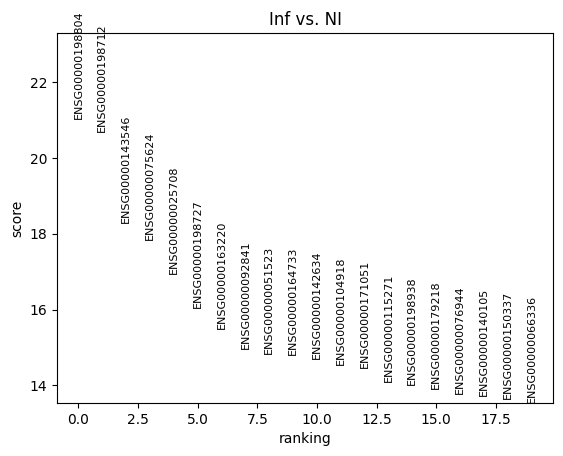


Scanpy DE results head for Inf in CD14 Mono:
             names     scores  logfoldchanges         pvals     pvals_adj
0  ENSG00000198804  21.038570       16.344753  2.910141e-98  2.910141e-94
1  ENSG00000198712  20.691887       16.966417  4.098506e-95  2.049253e-91
2  ENSG00000143546  18.280222       24.482088  1.189398e-74  3.964661e-71
3  ENSG00000075624  17.849115       13.464774  2.936500e-71  7.341249e-68
4  ENSG00000025708  16.930765        2.351377  2.668847e-64  5.337695e-61

Number of DEGs found by Scanpy (wilcoxon, p_adj<0.05, |lfc|>0.25): 715
  Upregulated: 654
  Downregulated: 61


In [73]:
# === Cell 1.5: Sanity Check with Scanpy DE (Optional) ===
import scanpy as sc

# --- Parameters for Scanpy DE ---
test_cell_type = 'CD14 Mono' # Choose one cell type to test
scanpy_method = 'wilcoxon' # Or 't-test', 'logreg'

# --- Prepare data for the chosen cell type ---
# Make sure data is normalized (e.g., log1p)
# If not normalized in adata.X, specify the layer
adata_subset = adata[(adata.obs[cell_type_key] == test_cell_type)].copy()

if adata_subset.n_obs > 0:
    print(f"\n--- Running Scanpy {scanpy_method} test for {test_cell_type} ---")
    print(f"Comparing groups in '{condition_key}': {adata_subset.obs[condition_key].unique()}")

    # Use condition_key for grouping, compare condition1 vs condition2
    sc.tl.rank_genes_groups(
        adata_subset,
        groupby=condition_key,
        groups=[condition1], # Group to test (e.g., 'Infected')
        reference=condition2, # Reference group (e.g., 'Non-infected')
        method=scanpy_method,
        use_raw=False # Set True if using adata.raw, otherwise uses adata.X or specified layer
        # layer=... # Specify layer if counts are not in X
    )

    # Show top genes
    print(f"Top genes for {condition1} in {test_cell_type} (Scanpy):")
    sc.pl.rank_genes_groups(adata_subset, n_genes=20, sharey=False, show=True)

    # Get results as DataFrame
    scanpy_res = sc.get.rank_genes_groups_df(adata_subset, group=condition1)
    print(f"\nScanpy DE results head for {condition1} in {test_cell_type}:")
    print(scanpy_res.head())

    # Check counts based on adjusted p-value and LFC
    pval_adj_cutoff = 0.05
    lfc_scanpy_cutoff = 0.25 # Or 0.0
    scanpy_degs = scanpy_res[
        (scanpy_res['pvals_adj'] < pval_adj_cutoff) & \
        (abs(scanpy_res['logfoldchanges']) > lfc_scanpy_cutoff)
    ]
    print(f"\nNumber of DEGs found by Scanpy ({scanpy_method}, p_adj<{pval_adj_cutoff}, |lfc|>{lfc_scanpy_cutoff}): {len(scanpy_degs)}")
    print(f"  Upregulated: {len(scanpy_degs[scanpy_degs['logfoldchanges'] > 0])}")
    print(f"  Downregulated: {len(scanpy_degs[scanpy_degs['logfoldchanges'] < 0])}")
else:
    print(f"Skipping Scanpy test for {test_cell_type} - no cells found.")

In [74]:
# === Cell 2: Perform Differential Expression (Corrected) ===
import time # Import time for optional delay

de_results = []

print(f"\n--- Running DE ({condition1} vs {condition2}) for each cell type ---")

for cell_type in unique_cell_types:
    print(f"Processing: {cell_type}...")
    # Add a small delay - sometimes helps prevent weird backend issues in loops (optional)
    # time.sleep(0.1)

    # Define indices for the two groups within the current cell type
    idx1 = (adata.obs[cell_type_key] == cell_type) & (adata.obs[condition_key] == condition1)
    idx2 = (adata.obs[cell_type_key] == cell_type) & (adata.obs[condition_key] == condition2)

    n_cells1 = idx1.sum()
    n_cells2 = idx2.sum()

    if n_cells1 == 0 or n_cells2 == 0:
        print(f"  Skipping {cell_type}: Not enough cells in one or both conditions (Group1: {n_cells1}, Group2: {n_cells2}).")
        de_results.append({
            'cell_type': cell_type,
            'up_inf': 0,
            'down_inf': 0,
            'n_cells1': n_cells1,
            'n_cells2': n_cells2
        })
        continue

    print(f"  Comparing {n_cells1} '{condition1}' vs {n_cells2} '{condition2}' cells.")

# INSIDE Cell 2 - Replace the whole try...except block

    try:
        de_call_args = {
        'adata': adata,
            'idx1': idx1,
            'idx2': idx2,
            'batch_size': min(n_cells1, n_cells2, 128),
            'all_stats': True
        }

        # Adjust DE call based on de_type
        if de_type == 'bayes':
            print("    Running DE with mode='vanilla' for Bayesian test.")
        # mode='vanilla' is often default, let's try omitting mode and delta
        # If this causes errors, try explicitly adding mode='vanilla'
        elif de_type == 'fdr':
             print(f"    Running DE with mode='change', delta={lfc_threshold} for LFC estimation.")
             de_call_args['mode'] = 'change'
             de_call_args['delta'] = lfc_threshold # delta is specifically for mode='change'
        else:
             raise ValueError("de_type must be 'fdr' or 'bayes'")

    # Run differential expression
        de_df = model.differential_expression(**de_call_args)


    # --- Add the inspection print statement here ---
        print(f"  Raw DE stats summary for {cell_type}:")
        relevant_cols = [col for col in ['bayes_factor', 'proba_de', lfc_col] if col in de_df.columns]
        if relevant_cols:
             print(de_df[relevant_cols].describe())
        else:
             print("    Relevant DE stats columns not found.")
    # --------------------------------------------

    # --- Filter for Significance ---
        lfc_col = 'lfc_mean' # Log fold change column

        if de_type == "fdr":
        # Placeholder logic - Standard scVI DE doesn't easily give p-values for FDR
            if 'proba_de' in de_df.columns: # Use proba_de as a proxy
                significant = de_df['proba_de'] >= (1.0 - de_threshold)
                print(f"    Using proba_de >= {1.0 - de_threshold} for significance.")
            else:
                print(f"    Warning: Cannot apply FDR/proba filtering. 'proba_de' not found...")
                significant = pd.Series([False] * len(de_df), index=de_df.index) # Default to False if column missing

        elif de_type == "bayes":
            bayes_col = 'bayes_factor'
            if bayes_col not in de_df.columns:
                 print(f"    Warning: Bayes factor column '{bayes_col}' not found. Cannot filter.")
                 significant = pd.Series([False] * len(de_df), index=de_df.index) # Default to False
            else:
            # Filter only on Bayes Factor first if lfc_threshold is 0, otherwise combine
                if lfc_threshold == 0.0:
                   significant = (de_df[bayes_col] > de_threshold)
                else:
                   significant = (de_df[bayes_col] > de_threshold) & (abs(de_df[lfc_col]) > lfc_threshold)
                print(f"    Using Bayes Factor > {de_threshold} and |LFC| > {lfc_threshold} for significance.")
        else:
             raise ValueError("de_type must be 'fdr' or 'bayes'")

    # Filter based on significance and LFC direction
    # Ensure lfc_col exists before filtering
        if lfc_col not in de_df.columns:
             print(f"    Warning: LFC column '{lfc_col}' not found. Cannot calculate up/down regulated counts.")
             n_up, n_down = 0, 0
        else:
             up_sig = significant & (de_df[lfc_col] > lfc_threshold) # Use > lfc_threshold (which might be 0)
             down_sig = significant & (de_df[lfc_col] < -lfc_threshold) # Use < -lfc_threshold
             n_up = up_sig.sum()
             n_down = down_sig.sum()


        print(f"  Found: Upregulated={n_up}, Downregulated={n_down}")

        de_results.append({
            'cell_type': cell_type,
            'up_inf': n_up,
            'down_inf': n_down,
            'n_cells1': n_cells1,
            'n_cells2': n_cells2
        })

    except Exception as e:
        print(f"  ERROR processing {cell_type}: {e}")
        import traceback
        traceback.print_exc()
        de_results.append({
            'cell_type': cell_type,
            'up_inf': 0,
            'down_inf': 0,
            'n_cells1': n_cells1,
            'n_cells2': n_cells2
        })

# --- Create DataFrame ---
results_df = pd.DataFrame(de_results)
if not results_df.empty:
    # Set cell_type as index for easier plotting/lookup
    results_df = results_df.set_index('cell_type')
    # Reorder according to the desired plot order (if unique_cell_types was defined)
    if 'unique_cell_types' in locals():
        results_df = results_df.reindex(unique_cell_types).dropna(how='all') # Keep order, drop rows if cell type failed entirely

print("\n--- DE Results Summary ---")
print(results_df)


--- Running DE (Inf vs NI) for each cell type ---
Processing: CD14 Mono...
  Comparing 13245 'Inf' vs 6575 'NI' cells.
    Running DE with mode='vanilla' for Bayesian test.


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

  Raw DE stats summary for CD14 Mono:
       bayes_factor      proba_de      lfc_mean
count  10000.000000  10000.000000  10000.000000
mean      -0.238036      0.097841     -0.035373
std        2.554601      0.145173      0.100135
min       -8.516943      0.000000     -0.605497
25%       -0.521507      0.000000     -0.086620
50%       -0.000000      0.001200     -0.039197
75%        0.267178      0.194650      0.018993
max        8.516943      0.521400      0.725425
    Using Bayes Factor > 3 and |LFC| > 0.0 for significance.
  Found: Upregulated=140, Downregulated=558
Processing: CD16 Mono...
  Comparing 15223 'Inf' vs 4656 'NI' cells.
    Running DE with mode='vanilla' for Bayesian test.


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

  Raw DE stats summary for CD16 Mono:
       bayes_factor      proba_de      lfc_mean
count  10000.000000  10000.000000  10000.000000
mean       0.285400      0.083680     -0.016470
std        2.650131      0.131952      0.099429
min       -8.516943      0.000000     -0.810764
25%       -0.000000      0.000000     -0.063926
50%       -0.000000      0.000800     -0.011345
75%        0.787527      0.140950      0.033565
max        8.516943      0.540400      0.676707
    Using Bayes Factor > 3 and |LFC| > 0.0 for significance.
  Found: Upregulated=391, Downregulated=898
Processing: CD4 Naive...
  Comparing 26635 'Inf' vs 11945 'NI' cells.
    Running DE with mode='vanilla' for Bayesian test.


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

  Raw DE stats summary for CD4 Naive:
       bayes_factor      proba_de      lfc_mean
count  10000.000000  10000.000000  10000.000000
mean      -0.508085      0.055130      0.011821
std        2.837359      0.098931      0.037690
min       -8.516943      0.000000     -0.341484
25%       -1.407998      0.000000     -0.005112
50%       -0.000000      0.000200      0.009998
75%        0.000000      0.066850      0.030990
max        8.516943      0.506200      0.360009
    Using Bayes Factor > 3 and |LFC| > 0.0 for significance.
  Found: Upregulated=425, Downregulated=364
Processing: CD4 TCM...
  Comparing 26965 'Inf' vs 13208 'NI' cells.
    Running DE with mode='vanilla' for Bayesian test.


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

  Raw DE stats summary for CD4 TCM:
       bayes_factor      proba_de      lfc_mean
count  10000.000000  10000.000000  10000.000000
mean      -0.154525      0.070332      0.012972
std        2.698505      0.116415      0.043670
min       -8.516943      0.000000     -0.315686
25%       -0.983742      0.000000     -0.007309
50%       -0.000000      0.000400      0.013041
75%        0.000000      0.112600      0.036633
max        8.516943      0.492800      0.381463
    Using Bayes Factor > 3 and |LFC| > 0.0 for significance.
  Found: Upregulated=446, Downregulated=523
Processing: CD4 TEM...
  Comparing 2814 'Inf' vs 1585 'NI' cells.
    Running DE with mode='vanilla' for Bayesian test.


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

  Raw DE stats summary for CD4 TEM:
       bayes_factor      proba_de      lfc_mean
count  10000.000000  10000.000000  10000.000000
mean      -0.095586      0.078183      0.015501
std        2.484900      0.123114      0.061411
min       -8.516943      0.000000     -0.372716
25%       -0.545754      0.000000     -0.015497
50%       -0.000000      0.000400      0.016036
75%        0.000000      0.141200      0.046937
max        8.516943      0.519200      0.522781
    Using Bayes Factor > 3 and |LFC| > 0.0 for significance.
  Found: Upregulated=432, Downregulated=407
Processing: CD8 Naive...
  Comparing 12136 'Inf' vs 5091 'NI' cells.
    Running DE with mode='vanilla' for Bayesian test.


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

  Raw DE stats summary for CD8 Naive:
       bayes_factor      proba_de      lfc_mean
count  10000.000000  10000.000000  10000.000000
mean      -0.620877      0.051111      0.012801
std        2.823123      0.095369      0.038691
min       -8.516943      0.000000     -0.260817
25%       -1.418161      0.000000     -0.007294
50%       -0.000000      0.000000      0.014578
75%        0.000000      0.052850      0.032594
max        8.516943      0.492400      0.495777
    Using Bayes Factor > 3 and |LFC| > 0.0 for significance.
  Found: Upregulated=308, Downregulated=319
Processing: CD8 TEM...
  Comparing 14383 'Inf' vs 7534 'NI' cells.
    Running DE with mode='vanilla' for Bayesian test.


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

  Raw DE stats summary for CD8 TEM:
       bayes_factor      proba_de      lfc_mean
count  10000.000000  10000.000000  10000.000000
mean      -0.156638      0.060462     -0.012134
std        2.849492      0.109973      0.054297
min       -8.516943      0.000000     -0.442640
25%       -0.000000      0.000000     -0.036652
50%       -0.000000      0.000200     -0.008954
75%        0.263311      0.069450      0.013954
max        8.516943      0.501400      0.382801
    Using Bayes Factor > 3 and |LFC| > 0.0 for significance.
  Found: Upregulated=238, Downregulated=738
Processing: gdT...
  Comparing 5825 'Inf' vs 3310 'NI' cells.
    Running DE with mode='vanilla' for Bayesian test.


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

  Raw DE stats summary for gdT:
       bayes_factor      proba_de      lfc_mean
count  10000.000000  10000.000000  10000.000000
mean      -0.422825      0.078154      0.019358
std        2.707808      0.124957      0.061648
min       -8.516943      0.000000     -0.418437
25%       -1.127894      0.000000     -0.008311
50%       -0.000000      0.000400      0.022880
75%        0.000000      0.136400      0.053687
max        8.516943      0.490000      0.372373
    Using Bayes Factor > 3 and |LFC| > 0.0 for significance.
  Found: Upregulated=398, Downregulated=366
Processing: NK...
  Comparing 9119 'Inf' vs 5612 'NI' cells.
    Running DE with mode='vanilla' for Bayesian test.


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

  Raw DE stats summary for NK:
       bayes_factor      proba_de      lfc_mean
count  10000.000000  10000.000000  10000.000000
mean      -0.314913      0.069775      0.014592
std        2.645765      0.116470      0.055424
min       -8.516943      0.000000     -0.622625
25%       -0.925690      0.000000     -0.012731
50%       -0.000000      0.000400      0.018242
75%        0.000000      0.106000      0.043939
max        8.516943      0.512800      0.425100
    Using Bayes Factor > 3 and |LFC| > 0.0 for significance.
  Found: Upregulated=376, Downregulated=390

--- DE Results Summary ---
           up_inf  down_inf  n_cells1  n_cells2
cell_type                                      
CD14 Mono     140       558     13245      6575
CD16 Mono     391       898     15223      4656
CD4 Naive     425       364     26635     11945
CD4 TCM       446       523     26965     13208
CD4 TEM       432       407      2814      1585
CD8 Naive     308       319     12136      5091
CD8 TEM       238   


--- Generating DEG Bar Plot ---


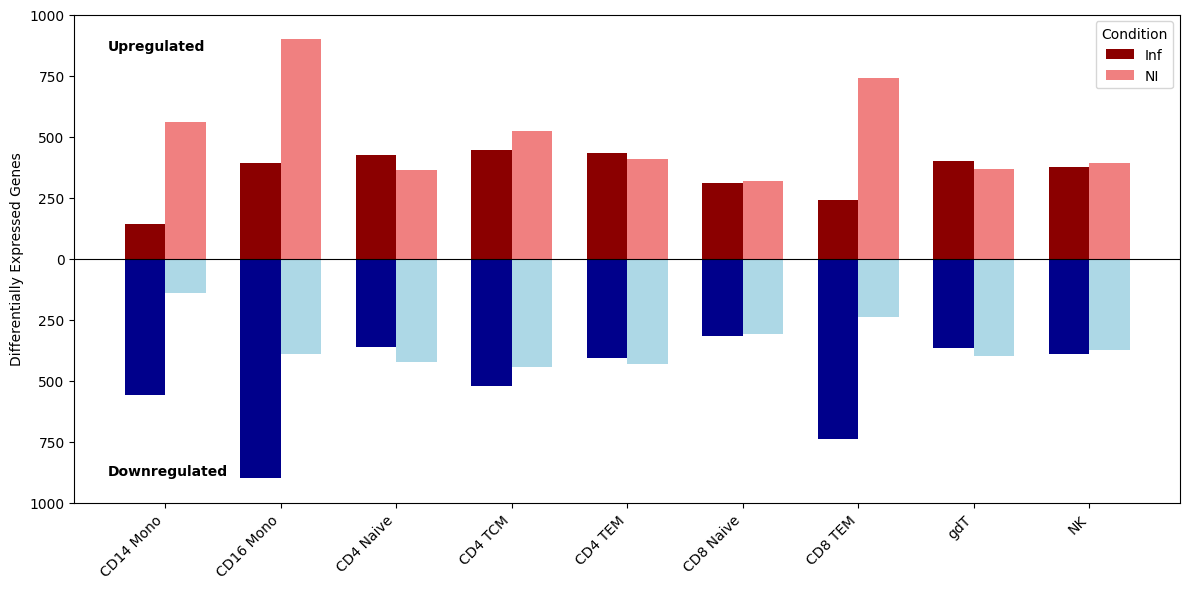

In [75]:
# === Cell 3: Generate the Plot ===

# Check if results_df exists and is not empty
if 'results_df' in locals() and not results_df.empty:
    print("\n--- Generating DEG Bar Plot ---")

    # Data for plotting
    labels = results_df.index
    up_infected = results_df['up_inf']      # For Dark Red & Light Blue bars
    down_infected = results_df['down_inf']  # For Pink & Dark Blue bars

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 6)) # Adjust figure size if needed

    # --- Plot Upregulated Genes (Y > 0) ---
    # Bar 1: Infected (Dark Red) - Represents up_inf
    rects1 = ax.bar(x - width/2, up_infected, width, label=condition1, color='darkred')
    # Bar 2: Non-infected (Pink) - Represents down_inf
    rects2 = ax.bar(x + width/2, down_infected, width, label=condition2, color='lightcoral') # Pink color

    # --- Plot Downregulated Genes (Y < 0) ---
    # Plotting below zero: Use negative values of the counts
    # Bar 3: Infected (Dark Blue) - Represents down_inf (plotted negative)
    rects3 = ax.bar(x - width/2, -down_infected, width, color='darkblue')
    # Bar 4: Non-infected (Light Blue) - Represents up_inf (plotted negative)
    rects4 = ax.bar(x + width/2, -up_infected, width, color='lightblue')

    # --- Add labels, title, and axes ticks ---
    ax.set_ylabel('Differentially Expressed Genes')
    # ax.set_title('DEGs by Cell Type and Condition') # Optional title
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right') # Rotate labels

    # Create a shared legend - combine labels from rects1 and rects2
    ax.legend(handles=[rects1, rects2], title="Condition")

    # Add a horizontal line at y=0
    ax.axhline(0, color='black', linewidth=0.8)

    # Adjust Y-axis labels for the "downregulated" part
    # Get current ticks and labels
    yticks = ax.get_yticks()
    yticklabels = [str(int(abs(y))) for y in yticks] # Show absolute numbers
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)

    # Add text labels for "Upregulated" and "Downregulated" regions (optional)
    # Find suitable y positions based on current limits
    ymin, ymax = ax.get_ylim()
    ax.text(-0.5, ymax * 0.9, 'Upregulated', ha='left', va='top', fontsize=10, weight='bold')
    ax.text(-0.5, ymin * 0.9, 'Downregulated', ha='left', va='bottom', fontsize=10, weight='bold')


    # Improve layout
    fig.tight_layout()

    # Show the plot
    plt.show()

else:
    print("\nSkipping plot generation because DE results DataFrame ('results_df') is missing or empty.")

In [76]:
# === Cell 1: Setup ===
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- Parameters ---

# <<< SET THESE PATHS AND KEYS >>>
# Path to the AnnData object containing final annotations and metadata
# This might be the output from clustering/UMAP steps, or loaded from a saved file
# adata_path = "adata_clustered_visualized.h5ad" # Or "/content/drive/MyDrive/path/to/your/adata_clustered_visualized.h5ad"

# --- Or --- If 'adata' is already loaded in your environment from previous steps:
# Make sure 'adata' contains the necessary columns specified below.
# Check if 'adata' exists, otherwise load from path
if 'adata' not in locals() or adata is None:
    print(f"Loading AnnData from: {adata_path}")
    if not os.path.exists(adata_path):
        raise FileNotFoundError(f"AnnData file not found: {adata_path}")
    adata = sc.read_h5ad(adata_path)
    print(f"Loaded AnnData: {adata.shape}")
else:
    print(f"Using AnnData object already in memory: {adata.shape}")


# Key in adata.obs for unique sample identifiers
sample_key = 'sample' # <<< e.g., 'sample_id', 'donor', 'sample'

# Key in adata.obs for cell type annotations to plot
cell_subtype_key = 'cell_subtype' # <<< e.g., 'cell_subtype', 'leiden_scvi_res1.0'

# Key in adata.obs for ethnicity
ethnicity_key = 'ethnicity' # <<< e.g., 'ethnicity'

# Key in adata.obs for infection status ('Inf', 'NI')
condition_key = 'infection_status' # <<< e.g., 'infection_status'

# Labels used within the ethnicity column (ensure these match your data)
ethnicity1 = 'Fulani'
ethnicity2 = 'Mossi'

# Labels used within the condition column (ensure these match your data)
condition1 = 'Inf' # Representing 'Infected'
condition2 = 'NI'  # Representing 'Non-infected'

# --- Basic Checks ---
required_cols = [sample_key, cell_subtype_key, ethnicity_key, condition_key]
missing_cols = [col for col in required_cols if col not in adata.obs.columns]
if missing_cols:
    raise KeyError(f"Missing required columns in adata.obs: {missing_cols}. Available: {adata.obs.columns.tolist()}")

print(f"Using columns: Sample='{sample_key}', CellType='{cell_subtype_key}', Ethnicity='{ethnicity_key}', Condition='{condition_key}'")

Using AnnData object already in memory: (380832, 10000)
Using columns: Sample='sample', CellType='cell_subtype', Ethnicity='ethnicity', Condition='infection_status'


In [77]:
# === Cell 2: Data Preparation ===

print("\n--- Calculating cell subtype proportions per sample ---")

# 1. Create the combined 'Identity' column (like FulInf, FuNI, etc.)
# Make sure the labels match your data and desired plot legend
adata.obs['Identity'] = (
    adata.obs[ethnicity_key].astype(str).str[:2] + # 'Fu' or 'Mo'
    adata.obs[condition_key].astype(str)           # 'Inf' or 'NI'
)
# Check the created categories
print(f"Created 'Identity' categories: {adata.obs['Identity'].unique().tolist()}")

# 2. Calculate counts of each cell type within each sample
counts_df = adata.obs.groupby([sample_key, cell_subtype_key]).size().unstack(fill_value=0)

# 3. Calculate proportions (percentages) within each sample
# Divide each row (sample) by its sum (total cells in that sample)
proportions_df = counts_df.apply(lambda x: x / x.sum() * 100, axis=1)

# 4. Merge with sample-level metadata (Identity)
# Get unique metadata per sample (assuming Identity is consistent within a sample)
sample_metadata = adata.obs[[sample_key, 'Identity']].drop_duplicates().set_index(sample_key)
proportions_df = proportions_df.merge(sample_metadata, left_index=True, right_index=True)

# 5. Reshape data to long format for Seaborn plotting
# This means having columns: sample_key, cell_subtype, proportion, Identity
proportions_long_df = proportions_df.reset_index().melt(
    id_vars=[sample_key, 'Identity'],
    var_name=cell_subtype_key, # The column names (cell types) become a variable
    value_name='Proportion'    # The values (proportions) become another variable
)

print("\n--- Data prepared for plotting (long format) ---")
print(proportions_long_df.head())


--- Calculating cell subtype proportions per sample ---
Created 'Identity' categories: ['MoInf', 'MoNI', 'nanan', 'FuNI', 'FuInf']

--- Data prepared for plotting (long format) ---
  sample Identity cell_subtype  Proportion
0      0    MoInf         ASDC    0.007413
1      0     MoNI         ASDC    0.007413
2      0    nanan         ASDC    0.007413
3      0     FuNI         ASDC    0.007413
4      0    FuInf         ASDC    0.007413


<ipython-input-77-0f3b50f73609>:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_df = adata.obs.groupby([sample_key, cell_subtype_key]).size().unstack(fill_value=0)



--- Generating Grouped Boxplot ---


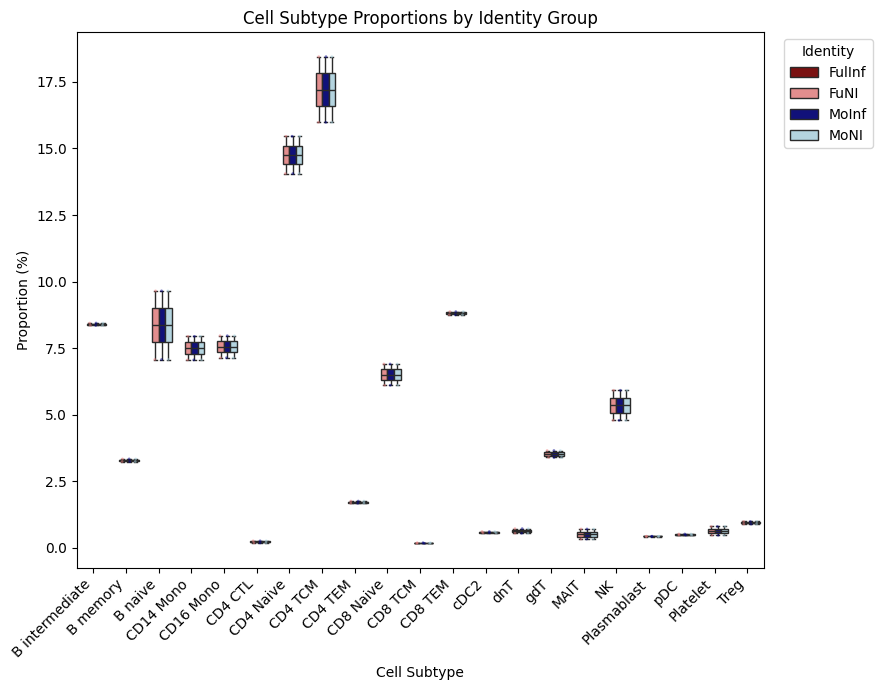


Plot generation complete.


In [82]:
# === Cell 3: Plotting ===

print("\n--- Generating Grouped Boxplot ---")

# Order cell types if desired (e.g., based on the reference plot)
cell_type_order = [
    'B intermediate', 'B memory', 'B naive', 'CD14 Mono', 'CD16 Mono',
    'CD4 CTL', 'CD4 Naive', 'CD4 TCM', 'CD4 TEM', 'CD8 Naive',
    'CD8 TCM', 'CD8 TEM', 'cDC2', 'dnT', 'gdT', 'MAIT',
    'NK', # <--- CHANGED FROM 'NK CD56+'
    'Plasmablast', 'pDC', 'Platelet', 'Treg'
] # <<< Adjust this list based on your actual cell types in cell_subtype_key column
# Filter the plotting dataframe to include only the types you want in the specified order
plot_df = proportions_long_df[proportions_long_df[cell_subtype_key].isin(cell_type_order)].copy()
# Ensure categorical ordering for plotting
plot_df[cell_subtype_key] = pd.Categorical(plot_df[cell_subtype_key], categories=cell_type_order, ordered=True)
plot_df.sort_values(cell_subtype_key, inplace=True)


# Define the order and colors for the Identity groups
identity_order = ['FulInf', 'FuNI', 'MoInf', 'MoNI'] # <<< Adjust if your generated names differ
palette = {'FulInf':'darkred', 'FuNI':'lightcoral', 'MoInf':'darkblue', 'MoNI':'lightblue'} # Colors from ref plot

plt.figure(figsize=(18, 7)) # Adjust figure size as needed

# Create the boxplot
ax = sns.boxplot(
    data=plot_df,
    x=cell_subtype_key,
    y='Proportion',
    hue='Identity',
    hue_order=identity_order,
    palette=palette,
    fliersize=0 # Hide outlier points, we might add strip plot below
)

# Optional: Overlay individual points (can be slow for many points)
ax = sns.stripplot(
    data=plot_df,
    x=cell_subtype_key,
    y='Proportion',
    hue='Identity',
    hue_order=identity_order,
    palette=palette,
    dodge=True, # Separate points for each hue group
    size=2,     # Adjust point size
    alpha=0.5,  # Adjust point transparency
    jitter=True # Add jitter to avoid overlap
)


# --- Customize Appearance ---
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels
plt.xlabel("Cell Subtype")
plt.ylabel("Proportion (%)")
plt.title("Cell Subtype Proportions by Identity Group") # Optional title

# Adjust legend
handles, labels = ax.get_legend_handles_labels()
# If using stripplot, legend might duplicate, take only first 4 handles/labels
ax.legend(handles[:len(identity_order)], labels[:len(identity_order)], title='Identity', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.5, 1]) # Adjust layout to make space for legend
plt.show()

print("\nPlot generation complete.")

In [80]:
print(adata.obs[cell_subtype_key].value_counts())

cell_subtype
CD4 TCM              40173
CD4 Naive            38580
CD8 TEM              21917
B intermediate       20914
CD16 Mono            19879
CD14 Mono            19820
B naive              17898
CD8 Naive            17227
NK                   14731
gdT                   9135
B memory              8122
CD4 TEM               4399
Eryth                 4197
Treg                  2246
MAIT                  1753
cDC2                  1424
dnT                   1393
Platelet              1214
pDC                   1211
Plasmablast           1105
NK_CD56bright          898
CD4 CTL                664
CD8 TCM                490
NK Proliferating       212
ILC                    176
HSPC                   165
CD4 Proliferating      128
CD8 Proliferating       74
Doublet                 56
cDC1                    50
ASDC                    18
Name: count, dtype: int64


# Volcano plots using scvi

In [102]:
# --- Define Metadata Keys and Labels ---
cell_subtype_key = 'cell_subtype'
ethnicity_key = 'ethnicity'
condition_key = 'infection_status'

group1_ethnicity = 'Fulani' # Group to compare (e.g., Numerator in LFC)
group2_ethnicity = 'Mossi'  # Reference group (e.g., Denominator in LFC)

condition_inf = 'Inf'
condition_ni = 'NI'

cell_type_cd14 = 'CD14 Mono'
cell_type_cd16 = 'CD16 Mono'

# --- Define DE Parameters (Bayesian) ---
de_type = 'bayes' # Use Bayesian method
# Bayes Factor threshold (higher is stricter, 3 is moderate evidence)
de_threshold = 0.0
# Log fold change threshold (set to 0 initially to see all significant by BF)
lfc_threshold = 0.0 # Log2 Fold Change threshold

# --- Load Data ---
print(f"Loading AnnData from: {adata_path}")
if not os.path.exists(adata_path):
    raise FileNotFoundError(f"AnnData file not found: {adata_path}")
adata = sc.read_h5ad(adata_path)
# Ensure necessary metadata columns exist
required_cols = [cell_subtype_key, ethnicity_key, condition_key]
missing_cols = [col for col in required_cols if col not in adata.obs.columns]
if missing_cols:
    raise KeyError(f"Missing required columns in adata.obs: {missing_cols}. Available: {adata.obs.columns.tolist()}")
print(f"Loaded AnnData: {adata.shape}")

# --- Load Model ---
print(f"Loading scVI model from: {model_dir}")
if not os.path.isdir(model_dir):
    raise FileNotFoundError(f"Model directory not found: {model_dir}")
# Link the loaded adata object to the model
# Use check_is_view=False if adata might be a view after filtering/loading
model = scvi.model.SCVI.load(model_dir, adata=adata) # Add GPU check if applicable
# Or if model was trained on a specific layer:
# model = scvi.model.SCVI.load(model_dir, adata=adata, use_gpu=torch.cuda.is_available(), accelerator="gpu" if torch.cuda.is_available() else "cpu") # Check syntax for accelerator
print("Model loaded successfully.")

# Make obs names unique if necessary
adata.obs_names_make_unique()

print("\nSetup complete for scVI Bayesian DE.")

Loading AnnData from: /content/drive/MyDrive/raw/adata_processed_annotated.h5ad
Loaded AnnData: (380832, 10000)
Loading scVI model from: /content/drive/MyDrive/raw/scvi_model
INFO     File /content/drive/MyDrive/raw/scvi_model/model.pt already downloaded                                    


/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Model loaded successfully.

Setup complete for scVI Bayesian DE.


In [103]:
# === Cell 2 (Revised): Run scVI Differential Expression (Bayesian) ===
import time

de_results = {} # Dictionary to store processed results DataFrames

comparisons = [
    {'label': f'{cell_type_cd14}_{condition_inf}', 'cell_type': cell_type_cd14, 'condition': condition_inf},
    {'label': f'{cell_type_cd14}_{condition_ni}', 'cell_type': cell_type_cd14, 'condition': condition_ni},
    {'label': f'{cell_type_cd16}_{condition_inf}', 'cell_type': cell_type_cd16, 'condition': condition_inf},
    {'label': f'{cell_type_cd16}_{condition_ni}', 'cell_type': cell_type_cd16, 'condition': condition_ni},
]

print(f"\n--- Running DE Tests (scVI Bayesian, BF > {de_threshold}, |LFC| > {lfc_threshold}) ---")

for comp in comparisons:
    label = comp['label']
    ct = comp['cell_type']
    cond = comp['condition']

    print(f"Processing: {label} ({group1_ethnicity} vs {group2_ethnicity})")
    time.sleep(0.1) # Small delay

    # 1. Define indices for the specific comparison
    idx1 = (adata.obs[cell_subtype_key] == ct) & \
           (adata.obs[condition_key] == cond) & \
           (adata.obs[ethnicity_key] == group1_ethnicity)
    idx2 = (adata.obs[cell_subtype_key] == ct) & \
           (adata.obs[condition_key] == cond) & \
           (adata.obs[ethnicity_key] == group2_ethnicity)

    n_cells1 = idx1.sum()
    n_cells2 = idx2.sum()

    # Check if groups exist and have enough cells
    if n_cells1 < 3 or n_cells2 < 3:
       print(f"  Skipping {label}: Not enough cells (Group1: {n_cells1}, Group2: {n_cells2}).")
       de_results[label] = None
       continue

    print(f"  Comparing {n_cells1} '{group1_ethnicity}' vs {n_cells2} '{group2_ethnicity}' cells.")

    try:
        # 2. Run differential expression using scVI model
        # We don't specify 'mode' to use default Bayesian testing
        # We don't specify 'delta' as it's for mode='change'
        de_df_raw = model.differential_expression(
            adata,
            idx1=idx1,
            idx2=idx2,
            all_stats=True, # Request Bayes factor, proba_de etc.
            batch_size=min(n_cells1, n_cells2, 128) # Adjust if needed
            # Removed mode, delta, use_observed_batches
        )

        # --- Process Results for Plotting ---
        print(f"  Raw DE stats summary for {label}:")
        cols_to_describe = [col for col in ['bayes_factor', 'proba_de', 'lfc_mean'] if col in de_df_raw.columns]
        if cols_to_describe:
             print(de_df_raw[cols_to_describe].describe())
        else:
             print("    Key stats columns (bayes_factor, proba_de, lfc_mean) not found.")
             de_results[label] = None
             continue # Skip if essential columns are missing

        # Check required columns for filtering and plotting
        if 'bayes_factor' not in de_df_raw.columns or 'lfc_mean' not in de_df_raw.columns:
             print(f"    Skipping {label}: Missing 'bayes_factor' or 'lfc_mean' column for filtering.")
             de_results[label] = None
             continue

        df_processed = pd.DataFrame(index=de_df_raw.index)
        df_processed['log2FoldChange'] = de_df_raw['lfc_mean']

        # Significance based on Bayes Factor and LFC
        df_processed['significant_bf'] = (de_df_raw['bayes_factor'] > de_threshold) & \
                                         (abs(df_processed['log2FoldChange']) > lfc_threshold)

        # Calculate Y-axis score for volcano plot
        # Option 1: Use proba_de if available
        if 'proba_de' in de_df_raw.columns:
            # Calculate -log10(1 - proba_de), handle proba_de=1 case
            proba_de_clipped = de_df_raw['proba_de'].clip(upper=(1.0 - 1e-300)) # Avoid log10(0)
            df_processed['significance_score_y'] = -np.log10(1.0 - proba_de_clipped)
            y_axis_label = "-Log10(1 - Proba DE)"
        # Option 2: Fallback - Use Bayes Factor (less standard for Y axis)
        # else:
        #    # Plot log10 Bayes Factor, add small value to avoid log10(<=0)
        #    bf_clipped = de_df_raw['bayes_factor'].clip(lower=1e-10)
        #    df_processed['significance_score_y'] = np.log10(bf_clipped)
        #    y_axis_label = "Log10 Bayes Factor"
        # Option 3: Add pseudo p-value if needed later. For now, let's rely on Option 1.
        elif 'bayes_factor' in de_df_raw.columns:
             # Fallback if proba_de not available - create pseudo-score from BF for ranking display
             # This is just for visualization height, significance is from 'significant_bf'
             print(f"    Warning: 'proba_de' not found for {label}. Using scaled Bayes Factor for Y-axis.")
             bf_scaled = np.log10(de_df_raw['bayes_factor'].clip(lower=1e-10))
             # Scale crudely for plotting range, might need adjustment
             bf_scaled = (bf_scaled - bf_scaled.min()) / (bf_scaled.max() - bf_scaled.min()) * 10
             df_processed['significance_score_y'] = bf_scaled.fillna(0)
             y_axis_label = "Scaled Log10 Bayes Factor (Visualization Only)"
        else:
             print(f"    Skipping {label}: Cannot determine Y-axis score ('proba_de' or 'bayes_factor' missing).")
             de_results[label] = None
             continue


        # Store processed results and the determined Y-axis label
        de_results[label] = {'df': df_processed, 'y_label': y_axis_label}
        print(f"  DE complete for {label}. Found {df_processed['significant_bf'].sum()} significant genes by BF/LFC.")

    except Exception as e:
        print(f"  ERROR processing {label}: {e}")
        import traceback
        traceback.print_exc()
        de_results[label] = None

print("\n--- All DE analyses finished ---")


--- Running DE Tests (scVI Bayesian, BF > 0.0, |LFC| > 0.0) ---
Processing: CD14 Mono_Inf (Fulani vs Mossi)
  Comparing 7789 'Fulani' vs 5456 'Mossi' cells.


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

  Raw DE stats summary for CD14 Mono_Inf:
       bayes_factor      proba_de      lfc_mean
count  10000.000000  10000.000000  10000.000000
mean      -0.207241      0.165891      0.180258
std        2.452626      0.257340      0.608536
min       -8.516943      0.000000     -4.236395
25%       -0.495920      0.000000     -0.047024
50%       -0.000000      0.001400      0.214645
75%        0.000000      0.300050      0.513857
max        8.516943      0.976000      2.786035
  DE complete for CD14 Mono_Inf. Found 2342 significant genes by BF/LFC.
Processing: CD14 Mono_NI (Fulani vs Mossi)
  Comparing 3881 'Fulani' vs 2694 'Mossi' cells.


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

  Raw DE stats summary for CD14 Mono_NI:
       bayes_factor      proba_de      lfc_mean
count  10000.000000  10000.000000  10000.000000
mean      -0.438289      0.174900      0.243253
std        2.400742      0.269902      0.617612
min       -8.516943      0.000000     -4.204165
25%       -0.659731      0.000000      0.003244
50%       -0.000000      0.001200      0.291807
75%        0.000000      0.321650      0.588326
max        8.516943      0.977000      2.860130
  DE complete for CD14 Mono_NI. Found 2234 significant genes by BF/LFC.
Processing: CD16 Mono_Inf (Fulani vs Mossi)
  Comparing 6931 'Fulani' vs 8292 'Mossi' cells.


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

  Raw DE stats summary for CD16 Mono_Inf:
       bayes_factor      proba_de      lfc_mean
count  10000.000000  10000.000000  10000.000000
mean       0.163869      0.135590      0.071946
std        2.561653      0.224523      0.466003
min       -8.516943      0.000000     -4.056857
25%       -0.308217      0.000000     -0.104106
50%       -0.000000      0.000800      0.096297
75%        0.000000      0.221350      0.333284
max        8.516943      0.977400      2.468203
  DE complete for CD16 Mono_Inf. Found 2494 significant genes by BF/LFC.
Processing: CD16 Mono_NI (Fulani vs Mossi)
  Comparing 2338 'Fulani' vs 2318 'Mossi' cells.


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

  Raw DE stats summary for CD16 Mono_NI:
       bayes_factor      proba_de      lfc_mean
count  10000.000000  10000.000000  10000.000000
mean      -0.238369      0.143772      0.159837
std        2.472867      0.231424      0.455297
min       -8.516943      0.000000     -3.640493
25%       -0.577101      0.000000     -0.004197
50%       -0.000000      0.001200      0.195775
75%        0.000000      0.245650      0.408999
max        8.516943      0.954400      2.400001
  DE complete for CD16 Mono_NI. Found 2160 significant genes by BF/LFC.

--- All DE analyses finished ---


In [104]:
# === Cell 3 (Revised): Volcano Plot Function (Adapted) ===

import math
from adjustText import adjust_text # Make sure it's installed: !pip install adjustText

def plot_volcano_scvi(de_result, title, lfc_cutoff=0.263, gene_label_count=10):
    """
    Generates a volcano plot from processed scVI DE results.

    Args:
        de_result (dict): Dict containing 'df' (DataFrame) and 'y_label' (str).
                          df must have 'log2FoldChange', 'significance_score_y',
                          and 'significant_bf' columns, indexed by gene.
        title (str): Title for the plot.
        lfc_cutoff (float): Log2 fold change cutoff for significance lines/coloring.
        gene_label_count (int): Number of top significant genes to label.
    """
    if de_result is None or de_result['df'].empty:
        print(f"Skipping plot '{title}': No DE results found or processed.")
        return

    df = de_result['df'].copy()
    y_axis_label = de_result['y_label']

    # Determine significance status string based on boolean
    df['Significance Type'] = 'Not Significant'
    cond_up = df['significant_bf'] & (df['log2FoldChange'] > lfc_threshold) # Use lfc_threshold from Cell 1
    cond_down = df['significant_bf'] & (df['log2FoldChange'] < -lfc_threshold) # Use lfc_threshold from Cell 1

    # Ensure we are using the LFC threshold set for the DE run for labeling
    sig_label_lfc = lfc_threshold if lfc_threshold > 0 else lfc_cutoff # Use actual cutoff if >0, else nominal for label

    df.loc[cond_up, 'Significance Type'] = f'Significant (BF > {de_threshold}, LFC > {sig_label_lfc:.2f})'
    df.loc[cond_down, 'Significance Type'] = f'Significant (BF > {de_threshold}, LFC < -{sig_label_lfc:.2f})'


    # --- Create Plot ---
    plt.figure(figsize=(7, 7))
    colors = {'Not Significant': 'grey',
              f'Significant (BF > {de_threshold}, LFC > {sig_label_lfc:.2f})': 'red',
              f'Significant (BF > {de_threshold}, LFC < -{sig_label_lfc:.2f})': 'blue'}

    sns.scatterplot(
        data=df,
        x='log2FoldChange',
        y='significance_score_y', # Use the calculated Y score
        hue='Significance Type',
        palette=colors,
        alpha=0.6,
        s=15,
        hue_order=colors.keys(),
        edgecolor=None
    )

    # --- Add Threshold Lines (Only for LFC) ---
    plt.axvline(x=lfc_cutoff, color='grey', linestyle='--', lw=1)
    plt.axvline(x=-lfc_cutoff, color='grey', linestyle='--', lw=1)
    # No horizontal line for BF/proba_de as significance is categorical color

    # --- Add Gene Labels (Optional) ---
    if gene_label_count > 0:
        df_sig = df[df['significant_bf']].copy() # Label genes passing BF/LFC filter
        # Sort by significance score first, then LFC magnitude
        df_sig['abs_lfc'] = abs(df_sig['log2FoldChange'])
        # Need a numeric significance score for sorting - use BF if available, else Y score
        sort_col = 'bayes_factor' if 'bayes_factor' in df_sig.columns else 'significance_score_y' # Requires adding BF to df_processed
        if sort_col not in df_sig.columns: # Add BF if missing for sorting
             if 'bayes_factor' in de_df_raw.columns: # Check original raw results
                  df_sig = df_sig.merge(de_df_raw[['bayes_factor']], left_index=True, right_index=True, how='left')
                  sort_col = 'bayes_factor' if 'bayes_factor' in df_sig.columns else 'significance_score_y'
             else:
                   sort_col = 'significance_score_y' # Fallback

        # Handle potential NaN in sort_col before sorting
        df_sig = df_sig.sort_values(by=[sort_col, 'abs_lfc'], ascending=[False, False], na_position='last')


        texts = []
        genes_to_label = df_sig.head(gene_label_count).index
        for gene in genes_to_label:
             if gene in df.index: # Ensure gene exists in plotted df
                  texts.append(plt.text(df.loc[gene, 'log2FoldChange'], df.loc[gene, 'significance_score_y'], gene, fontsize=8))
        if texts:
            try:
                 adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
            except NameError:
                 print("Consider installing `adjustText` (`pip install adjustText`) for better label placement.")


    # --- Final Touches ---
    plt.title(title)
    plt.xlabel("Log2 Fold Change (scVI lfc_mean)")
    plt.ylabel(y_axis_label) # Use dynamic label
    plt.grid(False)
    plt.legend(fontsize=8, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)
    plt.tight_layout(rect=[0, 0.05, 1, 1])


--- Generating Volcano Plots from scVI DE Results ---
5 [-0.58561753 -0.5019319 ]
6 [-0.65279089  0.99750533]


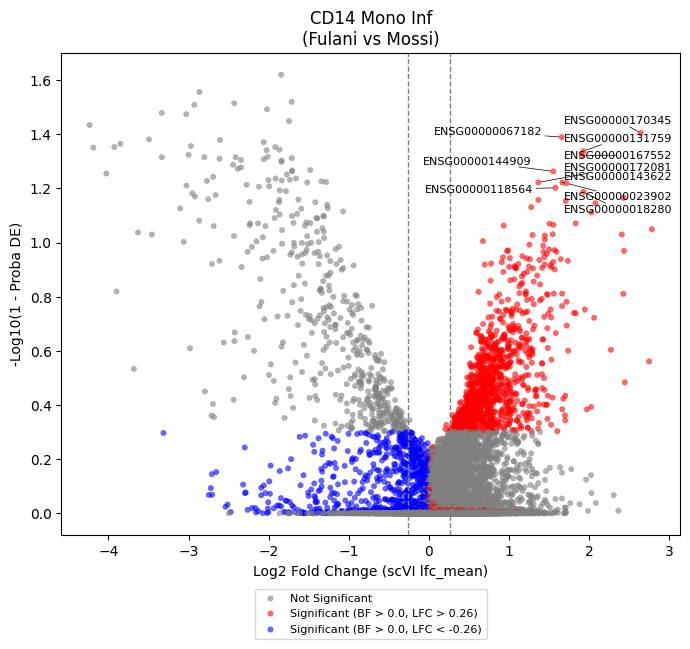

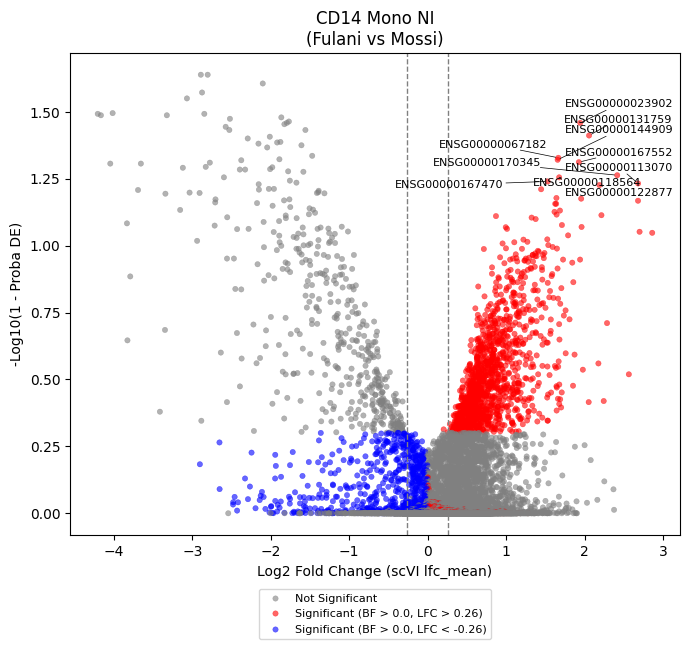

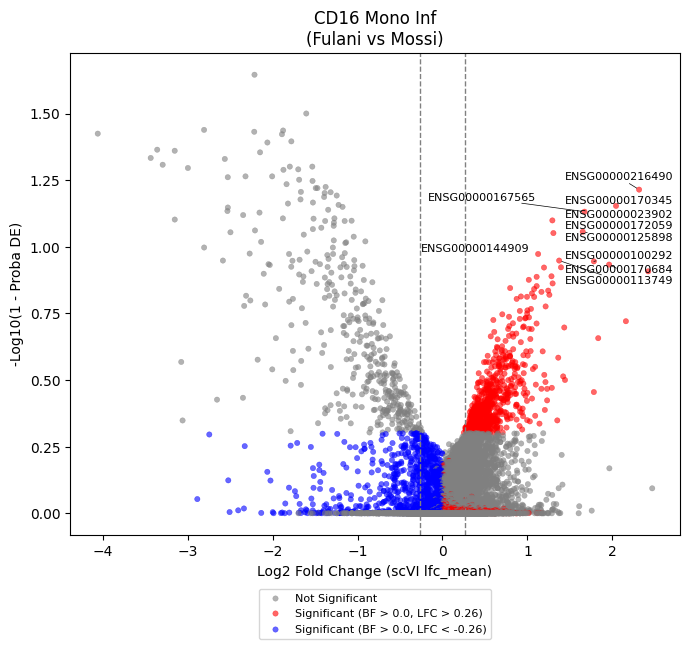

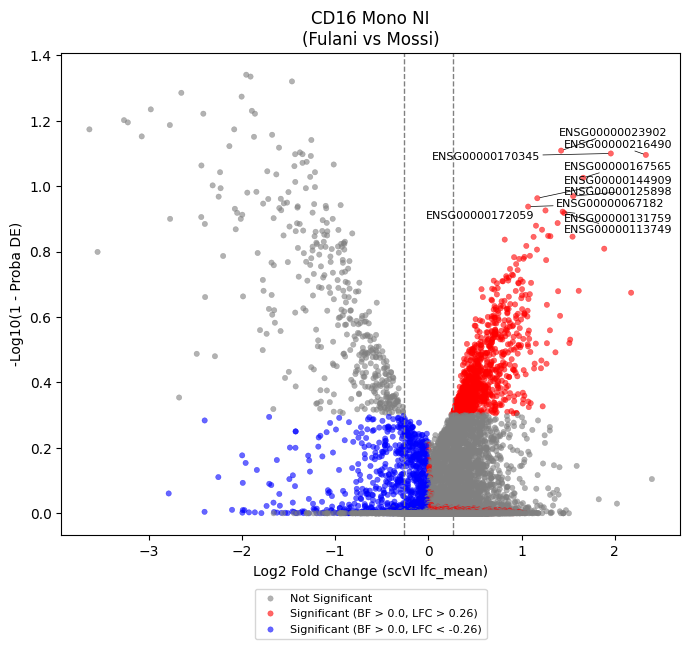


Volcano plot generation finished.


In [105]:
# === Cell 4 (Revised): Generate and Show Plots (using scVI results) ===

print("\n--- Generating Volcano Plots from scVI DE Results ---")

# --- Plot 1: CD14 Mono Infected ---
label1 = f'{cell_type_cd14}_{condition_inf}'
title1 = f"{cell_type_cd14} {condition_inf}\n({group1_ethnicity} vs {group2_ethnicity})"
if label1 in de_results:
    plot_volcano_scvi(de_results[label1], title=title1, lfc_cutoff=lfc_cutoff, gene_label_count=10)
    plt.show()
else:
    print(f"No results found for {label1}")

# --- Plot 2: CD14 Mono Non-infected ---
label2 = f'{cell_type_cd14}_{condition_ni}'
title2 = f"{cell_type_cd14} {condition_ni}\n({group1_ethnicity} vs {group2_ethnicity})"
if label2 in de_results:
    plot_volcano_scvi(de_results[label2], title=title2, lfc_cutoff=lfc_cutoff, gene_label_count=10)
    plt.show()
else:
    print(f"No results found for {label2}")

# --- Plot 3: CD16 Mono Infected ---
label3 = f'{cell_type_cd16}_{condition_inf}'
title3 = f"{cell_type_cd16} {condition_inf}\n({group1_ethnicity} vs {group2_ethnicity})"
if label3 in de_results:
    plot_volcano_scvi(de_results[label3], title=title3, lfc_cutoff=lfc_cutoff, gene_label_count=10)
    plt.show()
else:
    print(f"No results found for {label3}")

# --- Plot 4: CD16 Mono Non-infected ---
label4 = f'{cell_type_cd16}_{condition_ni}'
title4 = f"{cell_type_cd16} {condition_ni}\n({group1_ethnicity} vs {group2_ethnicity})"
if label4 in de_results:
    plot_volcano_scvi(de_results[label4], title=title4, lfc_cutoff=lfc_cutoff, gene_label_count=10)
    plt.show()
else:
    print(f"No results found for {label4}")


print("\nVolcano plot generation finished.")

# Volcano plots using scanpy

In [10]:
# === Cell 1: Setup, Normalization, Parameters ===
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.sparse

# --- Parameters ---

# <<< SET THESE PATHS AND KEYS >>>
# Path to AnnData object (assuming it has raw counts or suitable data for normalization)
adata_path = "/content/drive/MyDrive/raw/adata_scvi_trained.h5ad" # Or the processed annotated file

# --- Or --- If 'adata' is already loaded:
if 'adata' not in locals() or adata is None:
    print(f"Loading AnnData from: {adata_path}")
    if not os.path.exists(adata_path):
        raise FileNotFoundError(f"AnnData file not found: {adata_path}")
    adata = sc.read_h5ad(adata_path)
    print(f"Loaded AnnData: {adata.shape}")
else:
    # Ensure we have a copy if we might modify it
    adata = adata.copy()
    print(f"Using AnnData object already in memory: {adata.shape}")


# --- Define Metadata Keys and Labels ---
cell_subtype_key = 'cell_subtype'
ethnicity_key = 'ethnicity'
condition_key = 'infection_status'

group1_ethnicity = 'Fulani' # Group to compare (e.g., Numerator in LFC)
group2_ethnicity = 'Mossi'  # Reference group (e.g., Denominator in LFC)

condition_inf = 'Inf'
condition_ni = 'NI'

cell_type_cd14 = 'CD14 Mono'
cell_type_cd16 = 'CD16 Mono'

# --- Define DE Thresholds ---
# From paper caption: Padj < 0.05, log2FC > 0.263
padj_cutoff = 0.05
lfc_cutoff = 0.263 # Log2 Fold Change threshold

# --- Ensure Data is Normalized (Log1p) ---
# Check if data looks like counts (non-negative) or already log-transformed
# Use scipy.sparse.issparse to check the type of adata.X
print("Checking data format for normalization...")
data_sample = adata.X[:100, :100].toarray() if scipy.sparse.issparse(adata.X) else adata.X[:100, :100] # <<< CORRECTED THIS LINE


if np.all(data_sample >= 0) and np.max(data_sample) > 20: # Heuristic for counts
    print("Data looks like counts. Applying normalization and log1p...")
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    print("Normalization complete.")
    # Optional: store raw counts if needed elsewhere
    # adata.layers['counts'] = adata.raw.X.copy() if adata.raw is not None else adata.X.copy()
elif data_sample.min() >= 0 and np.max(data_sample) < 20:
     print("Data looks potentially log-transformed already (max value < 20). Skipping normalization.")
else:
     print("Data might be scaled or contain negative values. Assuming it's suitably processed for DE.")

# Make obs names unique if necessary (based on previous warnings)
adata.obs_names_make_unique()

print("\nSetup complete.")

Loading AnnData from: /content/drive/MyDrive/raw/adata_scvi_trained.h5ad
Loaded AnnData: (380832, 10000)
Checking data format for normalization...
Data looks like counts. Applying normalization and log1p...
Normalization complete.

Setup complete.


In [14]:
# === Cell 2: Run DE Analyses (Fulani vs. Mossi) ===

de_results = {} # Dictionary to store results DataFrames

comparisons = [
    {'label': f'{cell_type_cd14}_{condition_inf}', 'cell_type': cell_type_cd14, 'condition': condition_inf},
    {'label': f'{cell_type_cd14}_{condition_ni}', 'cell_type': cell_type_cd14, 'condition': condition_ni},
    {'label': f'{cell_type_cd16}_{condition_inf}', 'cell_type': cell_type_cd16, 'condition': condition_inf},
    {'label': f'{cell_type_cd16}_{condition_ni}', 'cell_type': cell_type_cd16, 'condition': condition_ni},
]

print("\n--- Running DE Tests (Scanpy Wilcoxon) ---")

for comp in comparisons:
    label = comp['label']
    ct = comp['cell_type']
    cond = comp['condition']

    print(f"Processing: {label} ({group1_ethnicity} vs {group2_ethnicity})")

    # 1. Subset adata for the specific cell type and condition
    adata_sub = adata[
        (adata.obs[cell_subtype_key] == ct) & \
        (adata.obs[condition_key] == cond)
    ].copy()

    # Check if both ethnicity groups are present
    if group1_ethnicity not in adata_sub.obs[ethnicity_key].unique() or \
       group2_ethnicity not in adata_sub.obs[ethnicity_key].unique():
       print(f"  Skipping {label}: One or both ethnicity groups missing in this subset.")
       de_results[label] = None # Indicate failure/skip
       continue

    n_g1 = (adata_sub.obs[ethnicity_key] == group1_ethnicity).sum()
    n_g2 = (adata_sub.obs[ethnicity_key] == group2_ethnicity).sum()
    print(f"  Subset shape: {adata_sub.shape}. Group1 '{group1_ethnicity}': {n_g1} cells. Group2 '{group2_ethnicity}': {n_g2} cells.")

    if n_g1 < 3 or n_g2 < 3: # Need minimum cells for reliable DE
        print(f"  Skipping {label}: Not enough cells in one or both groups for DE.")
        de_results[label] = None
        continue

    # 2. Run rank_genes_groups
    try:
        sc.tl.rank_genes_groups(
            adata_sub,
            groupby=ethnicity_key,
            groups=[group1_ethnicity],    # Group to test (numerator)
            reference=group2_ethnicity, # Reference group (denominator)
            method='wilcoxon',          # Wilcoxon rank-sum test
            use_raw=False,              # Use adata_sub.X (log-normalized)
            corr_method='benjamini-hochberg' # FDR correction
        )

        # 3. Extract results
        # Extract results for the comparison group (group1_ethnicity)
        res_df = sc.get.rank_genes_groups_df(adata_sub, group=group1_ethnicity)

        # Rename columns for clarity (match volcano plot expectations)
        res_df = res_df.rename(columns={
            'logfoldchanges': 'log2FoldChange',
            'pvals_adj': 'padj',
            'names': 'gene'
        })
        # Select and order relevant columns
        res_df = res_df[['gene', 'log2FoldChange', 'padj', 'pvals', 'scores']].set_index('gene')

        de_results[label] = res_df
        print(f"  DE complete for {label}. Found {len(res_df)} genes.")

    except Exception as e:
        print(f"  ERROR running DE for {label}: {e}")
        de_results[label] = None


print("\n--- All DE analyses finished ---")
# You can inspect results like: print(de_results[f'{cell_type_cd14}_{condition_inf}'].head())


--- Running DE Tests (Scanpy Wilcoxon) ---
Processing: CD14 Mono_Inf (Fulani vs Mossi)
  Subset shape: (13245, 10000). Group1 'Fulani': 7789 cells. Group2 'Mossi': 5456 cells.
  DE complete for CD14 Mono_Inf. Found 10000 genes.
Processing: CD14 Mono_NI (Fulani vs Mossi)
  Subset shape: (6575, 10000). Group1 'Fulani': 3881 cells. Group2 'Mossi': 2694 cells.
  DE complete for CD14 Mono_NI. Found 10000 genes.
Processing: CD16 Mono_Inf (Fulani vs Mossi)
  Subset shape: (15223, 10000). Group1 'Fulani': 6931 cells. Group2 'Mossi': 8292 cells.
  DE complete for CD16 Mono_Inf. Found 10000 genes.
Processing: CD16 Mono_NI (Fulani vs Mossi)
  Subset shape: (4656, 10000). Group1 'Fulani': 2338 cells. Group2 'Mossi': 2318 cells.
  DE complete for CD16 Mono_NI. Found 10000 genes.

--- All DE analyses finished ---


In [15]:
# === Cell 3: Volcano Plot Function ===

import math

def plot_volcano(de_df, title, lfc_cutoff=0.263, padj_cutoff=0.05, gene_label_count=10):
    """
    Generates a volcano plot from DE results.

    Args:
        de_df (pd.DataFrame): DataFrame with 'log2FoldChange' and 'padj' columns, indexed by gene.
        title (str): Title for the plot.
        lfc_cutoff (float): Log2 fold change cutoff for significance.
        padj_cutoff (float): Adjusted p-value cutoff for significance.
        gene_label_count (int): Number of top significant genes to label.
    """
    if de_df is None or de_df.empty:
        print(f"Skipping plot '{title}': No DE results found.")
        return

    # --- Prepare data ---
    df = de_df.copy()

    # Calculate -log10(padj), handle p=0 or NaN values
    df['-log10_padj'] = -np.log10(df['padj'].fillna(1.0).clip(lower=1e-300)) # Replace NaN with 1, clip very small values

    # Determine significance status
    df['significant'] = 'Not Significant'
    cond_up = (df['padj'] < padj_cutoff) & (df['log2FoldChange'] > lfc_cutoff)
    cond_down = (df['padj'] < padj_cutoff) & (df['log2FoldChange'] < -lfc_cutoff)
    df.loc[cond_up, 'significant'] = f'Upregulated (LFC > {lfc_cutoff}, Padj < {padj_cutoff})'
    df.loc[cond_down, 'significant'] = f'Downregulated (LFC < -{lfc_cutoff}, Padj < {padj_cutoff})'

    # --- Create Plot ---
    plt.figure(figsize=(7, 7))
    colors = {'Not Significant': 'grey',
              f'Upregulated (LFC > {lfc_cutoff}, Padj < {padj_cutoff})': 'red',
              f'Downregulated (LFC < -{lfc_cutoff}, Padj < {padj_cutoff})': 'blue'}
    alpha = {'Not Significant': 0.3,
             f'Upregulated (LFC > {lfc_cutoff}, Padj < {padj_cutoff})': 0.7,
             f'Downregulated (LFC < -{lfc_cutoff}, Padj < {padj_cutoff})': 0.7}

    sns.scatterplot(
        data=df,
        x='log2FoldChange',
        y='-log10_padj',
        hue='significant',
        palette=colors,
        alpha=0.6, # General alpha
        s=15, # point size
        hue_order=colors.keys(), # Ensure consistent legend order
        edgecolor=None
    )

    # --- Add Threshold Lines ---
    plt.axhline(y=-np.log10(padj_cutoff), color='grey', linestyle='--', lw=1)
    plt.axvline(x=lfc_cutoff, color='grey', linestyle='--', lw=1)
    plt.axvline(x=-lfc_cutoff, color='grey', linestyle='--', lw=1)

    # --- Add Gene Labels (Optional) ---
    if gene_label_count > 0:
        # Select top significant genes (up and down) to label
        df_sig = df[df['significant'] != 'Not Significant'].copy()
        # Sort by significance first, then LFC magnitude
        df_sig['abs_lfc'] = abs(df_sig['log2FoldChange'])
        df_sig = df_sig.sort_values(by=['padj', 'abs_lfc'], ascending=[True, False])

        texts = []
        from adjustText import adjust_text # Install if needed: !pip install adjustText
        genes_to_label = df_sig.head(gene_label_count).index
        for gene in genes_to_label:
              texts.append(plt.text(df.loc[gene, 'log2FoldChange'], df.loc[gene, '-log10_padj'], gene, fontsize=8))
        if texts:
            adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5))


    # --- Final Touches ---
    plt.title(title)
    plt.xlabel("Log2 Fold Change")
    plt.ylabel("-Log10 Adjusted P-value")
    plt.grid(False) # Remove background grid if desired
    # Adjust x/y limits if needed
    # xmax = max(abs(df['log2FoldChange'].min()), abs(df['log2FoldChange'].max())) * 1.1
    # plt.xlim(-xmax, xmax)

    plt.legend(fontsize=8, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1) # Adjust legend position
    plt.tight_layout(rect=[0, 0.05, 1, 1]) # Adjust layout slightly

In [18]:
pip install adjustText


--- Generating Volcano Plots ---


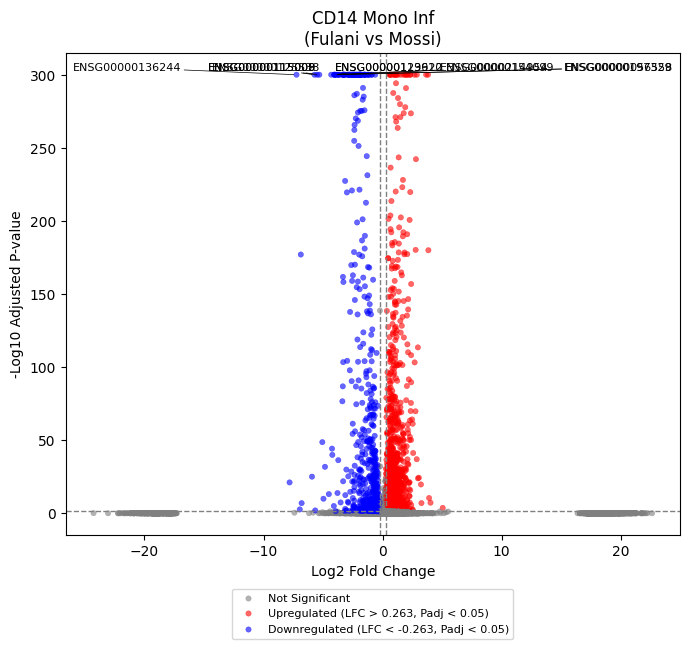

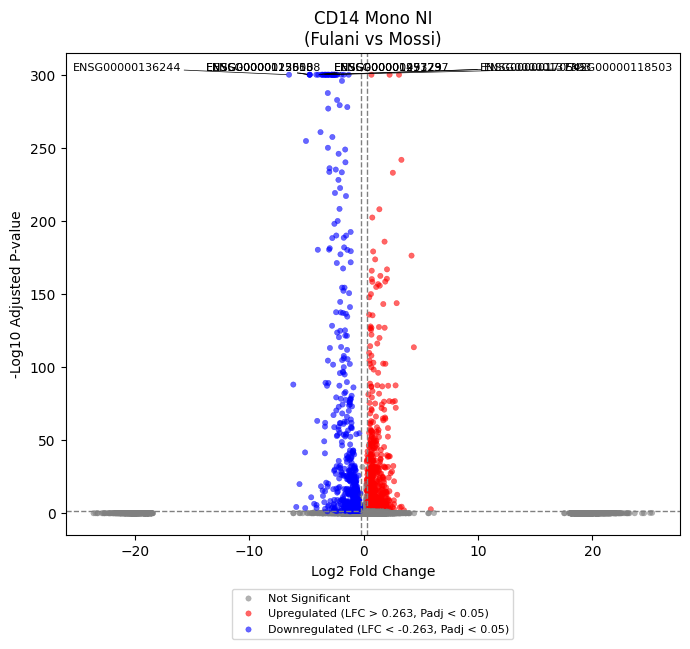

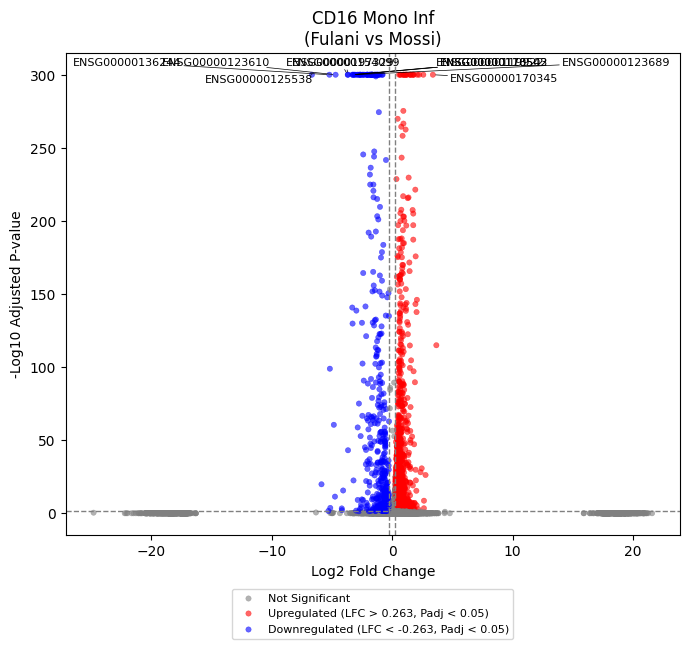

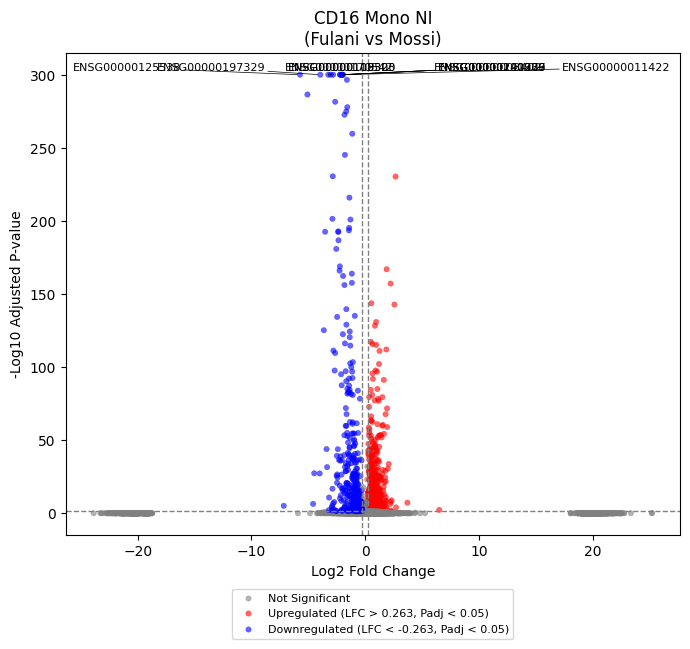


Volcano plot generation finished.


In [19]:
# === Cell 4: Generate and Show Plots ===
import seaborn as sns
import math

print("\n--- Generating Volcano Plots ---")

# --- Plot 1: CD14 Mono Infected ---
title1 = f"{cell_type_cd14} {condition_inf}\n({group1_ethnicity} vs {group2_ethnicity})"
plot_volcano(de_results[f'{cell_type_cd14}_{condition_inf}'], title=title1, lfc_cutoff=lfc_cutoff, padj_cutoff=padj_cutoff)
plt.show()

# --- Plot 2: CD14 Mono Non-infected ---
title2 = f"{cell_type_cd14} {condition_ni}\n({group1_ethnicity} vs {group2_ethnicity})"
plot_volcano(de_results[f'{cell_type_cd14}_{condition_ni}'], title=title2, lfc_cutoff=lfc_cutoff, padj_cutoff=padj_cutoff)
plt.show()

# --- Plot 3: CD16 Mono Infected ---
title3 = f"{cell_type_cd16} {condition_inf}\n({group1_ethnicity} vs {group2_ethnicity})"
plot_volcano(de_results[f'{cell_type_cd16}_{condition_inf}'], title=title3, lfc_cutoff=lfc_cutoff, padj_cutoff=padj_cutoff)
plt.show()

# --- Plot 4: CD16 Mono Non-infected ---
title4 = f"{cell_type_cd16} {condition_ni}\n({group1_ethnicity} vs {group2_ethnicity})"
plot_volcano(de_results[f'{cell_type_cd16}_{condition_ni}'], title=title4, lfc_cutoff=lfc_cutoff, padj_cutoff=padj_cutoff)
plt.show()

print("\nVolcano plot generation finished.")

In [20]:
# Run this if 'Identity' column doesn't exist in adata.obs
if 'Identity' not in adata.obs.columns:
     print("Creating 'Identity' column...")
     adata.obs['Identity'] = (
         adata.obs[ethnicity_key].astype(str).str[:2] +
         adata.obs[condition_key].astype(str)
     )
     print(f"Created 'Identity' categories: {adata.obs['Identity'].unique().tolist()}")
else:
     print("'Identity' column already exists.")

Creating 'Identity' column...
Created 'Identity' categories: ['MoInf', 'MoNI', 'nanan', 'FuNI', 'FuInf']


In [21]:
# === Cell 5: Select Top DE Genes for Heatmaps ===

print("\n--- Selecting Top DE Genes (Fulani vs Mossi in Non-infected) ---")

# Make sure the DE results dictionary exists from Cell 2 (Scanpy DE)
if 'de_results' not in locals():
    raise NameError("DE results dictionary ('de_results') not found. Please re-run Cell 2 (Scanpy DE).")

# Define parameters
n_top_genes = 45 # Number of up/down genes as per paper
# Use the same cutoffs as volcano plots for significance
# padj_cutoff = 0.05
# lfc_cutoff = 0.263

# --- Get Genes for CD14 Mono Heatmap (Panel B) ---
label_cd14_ni = f'{cell_type_cd14}_{condition_ni}'
de_cd14_ni = de_results.get(label_cd14_ni)
top_genes_cd14 = []

if de_cd14_ni is not None and not de_cd14_ni.empty:
    print(f"\nSelecting genes for CD14 Mono (using {label_cd14_ni} results)...")
    # Filter significant genes
    sig_genes_cd14 = de_cd14_ni[de_cd14_ni['padj'] < padj_cutoff]
    sig_genes_up_cd14 = sig_genes_cd14[sig_genes_cd14['log2FoldChange'] > lfc_cutoff]
    sig_genes_down_cd14 = sig_genes_cd14[sig_genes_cd14['log2FoldChange'] < -lfc_cutoff]

    # Sort by significance (padj ascending) then LFC magnitude (descending)
    sig_genes_up_cd14 = sig_genes_up_cd14.sort_values(by=['padj', 'log2FoldChange'], ascending=[True, False])
    sig_genes_down_cd14 = sig_genes_down_cd14.sort_values(by=['padj', 'log2FoldChange'], ascending=[True, True]) # Sort by LFC ascending for down

    # Get top N genes
    top_up_cd14 = sig_genes_up_cd14.head(n_top_genes).index.tolist()
    top_down_cd14 = sig_genes_down_cd14.head(n_top_genes).index.tolist()
    top_genes_cd14 = top_down_cd14 + top_up_cd14 # Order: Down first then Up

    print(f"  Found {len(top_up_cd14)} UP genes passing thresholds.")
    print(f"  Found {len(top_down_cd14)} DOWN genes passing thresholds.")
    print(f"  Total selected genes for CD14 Mono heatmap: {len(top_genes_cd14)}")
else:
    print(f"Warning: DE results for {label_cd14_ni} not found or empty. Cannot select genes for CD14 Mono heatmap.")


# --- Get Genes for CD16 Mono Heatmap (Panel C) ---
label_cd16_ni = f'{cell_type_cd16}_{condition_ni}'
de_cd16_ni = de_results.get(label_cd16_ni)
top_genes_cd16 = []

if de_cd16_ni is not None and not de_cd16_ni.empty:
    print(f"\nSelecting genes for CD16 Mono (using {label_cd16_ni} results)...")
     # Filter significant genes
    sig_genes_cd16 = de_cd16_ni[de_cd16_ni['padj'] < padj_cutoff]
    sig_genes_up_cd16 = sig_genes_cd16[sig_genes_cd16['log2FoldChange'] > lfc_cutoff]
    sig_genes_down_cd16 = sig_genes_cd16[sig_genes_cd16['log2FoldChange'] < -lfc_cutoff]

    # Sort by significance (padj ascending) then LFC magnitude (descending)
    sig_genes_up_cd16 = sig_genes_up_cd16.sort_values(by=['padj', 'log2FoldChange'], ascending=[True, False])
    sig_genes_down_cd16 = sig_genes_down_cd16.sort_values(by=['padj', 'log2FoldChange'], ascending=[True, True])

    # Get top N genes
    top_up_cd16 = sig_genes_up_cd16.head(n_top_genes).index.tolist()
    top_down_cd16 = sig_genes_down_cd16.head(n_top_genes).index.tolist()
    top_genes_cd16 = top_down_cd16 + top_up_cd16

    print(f"  Found {len(top_up_cd16)} UP genes passing thresholds.")
    print(f"  Found {len(top_down_cd16)} DOWN genes passing thresholds.")
    print(f"  Total selected genes for CD16 Mono heatmap: {len(top_genes_cd16)}")
else:
    print(f"Warning: DE results for {label_cd16_ni} not found or empty. Cannot select genes for CD16 Mono heatmap.")

print("\n--- Gene selection finished ---")


--- Selecting Top DE Genes (Fulani vs Mossi in Non-infected) ---

Selecting genes for CD14 Mono (using CD14 Mono_NI results)...
  Found 45 UP genes passing thresholds.
  Found 45 DOWN genes passing thresholds.
  Total selected genes for CD14 Mono heatmap: 90

Selecting genes for CD16 Mono (using CD16 Mono_NI results)...
  Found 45 UP genes passing thresholds.
  Found 45 DOWN genes passing thresholds.
  Total selected genes for CD16 Mono heatmap: 90

--- Gene selection finished ---



--- Generating CD14 Mono Heatmap with Gene Labels & LFC ---
Subsetted data for CD14 Mono heatmap: (19820, 90)
Data scaled.
Prepared column colors.
Generating clustermap...


/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


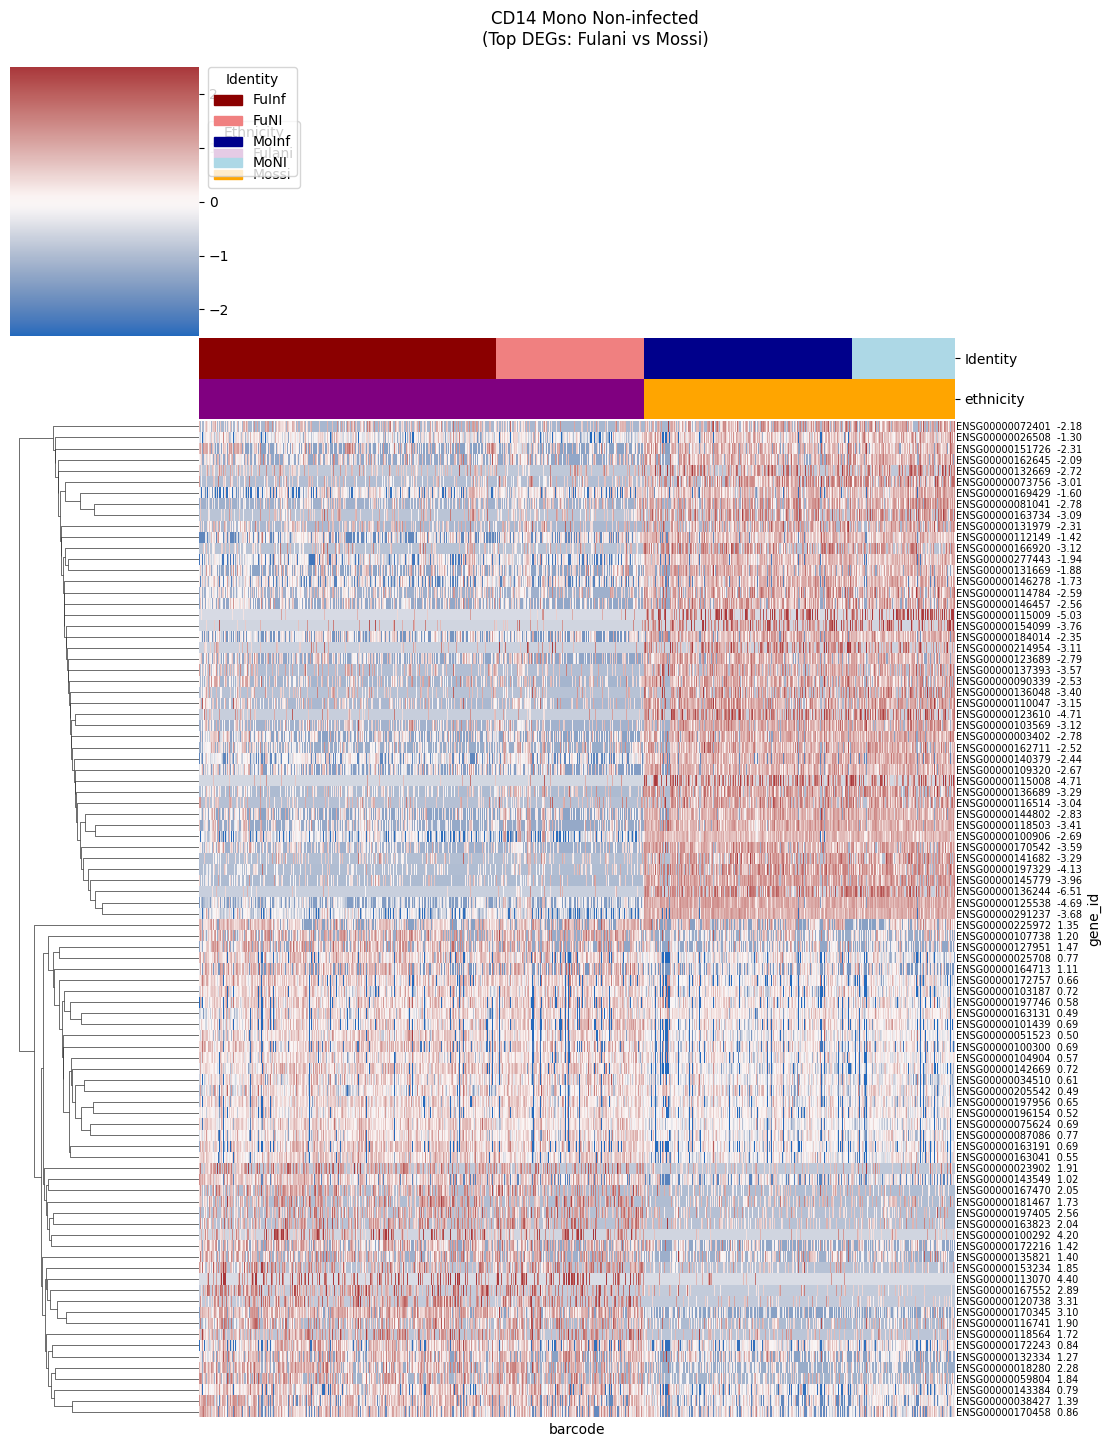


CD14 Mono heatmap generation finished (or skipped).


In [47]:
# === Cell 6 (Revised + Gene Labels): Generate CD14 Mono Heatmap ===
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc # Still need scanpy for scaling
import numpy as np # Needed for isnan check

print("\n--- Generating CD14 Mono Heatmap with Gene Labels & LFC ---")

# Check if required variables exist
if 'top_genes_cd14' not in locals() or not top_genes_cd14:
    print("Skipping CD14 Mono heatmap: Gene list ('top_genes_cd14') not found (Run Cell 5).")
elif 'de_results' not in locals() or f'{cell_type_cd14}_{condition_ni}' not in de_results or de_results[f'{cell_type_cd14}_{condition_ni}'] is None:
    print(f"Skipping CD14 Mono heatmap: DE results for '{cell_type_cd14}_{condition_ni}' not found (Run Cell 2 - Scanpy DE).")
else:
    # Get the relevant DE results for LFC values
    de_cd14_ni = de_results[f'{cell_type_cd14}_{condition_ni}']

    # 1. Subset AnnData
    adata_sub = adata[adata.obs[cell_subtype_key] == cell_type_cd14, top_genes_cd14].copy()
    print(f"Subsetted data for CD14 Mono heatmap: {adata_sub.shape}")

    if adata_sub.n_obs == 0 or adata_sub.n_vars == 0:
        print("Skipping CD14 Mono heatmap: Subset resulted in zero cells or genes.")
    else:
        # 2. Scale data
        sc.pp.scale(adata_sub, max_value=10) # Z-score genes, clip values
        print("Data scaled.")

        # 3. Get data into pandas DataFrame (Genes x Cells)
        plot_df = pd.DataFrame(adata_sub.X, index=adata_sub.obs_names, columns=adata_sub.var_names).T # Genes as index, Cells as columns

        # 4. Prepare Column Metadata and Colors
        col_meta_sorted = adata_sub.obs.sort_values(by=['Identity', ethnicity_key])
        plot_df_sorted = plot_df[col_meta_sorted.index] # Reorder columns (cells)

        identity_palette = {'FuInf':'darkred', 'FuNI':'lightcoral', 'MoInf':'darkblue', 'MoNI':'lightblue'}
        ethnicity_palette = {'Fulani': 'purple', 'Mossi': 'orange'}

        col_colors_mapped = col_meta_sorted[['Identity', ethnicity_key]].copy()
        col_colors_mapped['Identity'] = col_meta_sorted['Identity'].map(identity_palette)
        col_colors_mapped[ethnicity_key] = col_meta_sorted[ethnicity_key].map(ethnicity_palette)
        print("Prepared column colors.")

        # 5. Plot using seaborn.clustermap
        print("Generating clustermap...")
        try:
            g = sns.clustermap(
                plot_df_sorted, # Genes as rows, sorted Cells as columns
                row_cluster=True,
                col_cluster=False,
                col_colors=col_colors_mapped,
                standard_scale=None, # Data is already scaled by sc.pp.scale
                cmap='vlag',
                vmin=-2.5, vmax=2.5,
                linewidths=0,
                figsize=(12, 14), # Increase height for labels
                xticklabels=False,
                yticklabels=True # <<< Show Y tick labels (will be replaced)
            )

            # --- Add Custom Gene + LFC Labels ---
            # Get the gene order from the dendrogram
            ordered_gene_indices = g.dendrogram_row.reordered_ind
            ordered_gene_names = plot_df_sorted.index[ordered_gene_indices]

            # Create custom labels: "GeneName LFC_Value"
            custom_labels = []
            for gene in ordered_gene_names:
                if gene in de_cd14_ni.index:
                    lfc = de_cd14_ni.loc[gene, 'log2FoldChange']
                    # Check if lfc is NaN before formatting
                    lfc_str = f"{lfc:.2f}" if not np.isnan(lfc) else "N/A"
                    custom_labels.append(f"{gene}  {lfc_str}")
                else:
                    custom_labels.append(f"{gene}  N/A") # Handle genes not in DE results
            # Apply custom labels to the heatmap axes
            g.ax_heatmap.set_yticklabels(
                custom_labels,
                rotation=0,
                ha='left',
                fontsize=7 # <<< TRY ADJUSTING FONT SIZE (e.g., 6, 7, 8)
            )
            g.ax_heatmap.tick_params(axis='y', pad=0.5, length=0)

            # --- Final Touches ---
            # Rotate dendrogram if desired
            # g.ax_row_dendrogram.set_visible(False)

            # Add legend for annotations manually
            handles_id = [plt.Rectangle((0,0),1,1, color=identity_palette[label]) for label in identity_palette]
            leg1 = plt.legend(handles_id, identity_palette.keys(), title='Identity', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            # Add legend for ethnicity
            handles_eth = [plt.Rectangle((0,0),1,1, color=ethnicity_palette[label]) for label in ethnicity_palette]
            leg2 = plt.legend(handles_eth, ethnicity_palette.keys(), title='Ethnicity', bbox_to_anchor=(1.05, 0.8), loc='upper left', borderaxespad=0.) # Adjust vertical position
            g.fig.add_artist(leg1) # Need to re-add first legend after creating second


            plt.suptitle(f"{cell_type_cd14} Non-infected\n(Top DEGs: {group1_ethnicity} vs {group2_ethnicity})", y=1.03) # Updated Title
            # Adjust layout slightly to prevent overlap
            g.fig.subplots_adjust(right=0.8) # Make space for legends/labels on the right

            plt.show()

        except Exception as e:
              print(f"Error during seaborn.clustermap or labeling: {e}")
              import traceback
              traceback.print_exc()


print("\nCD14 Mono heatmap generation finished (or skipped).")


--- Generating CD16 Mono Heatmap (using Seaborn Clustermap) ---
Subsetted data for CD16 Mono heatmap: (19879, 90)
Data scaled.
Prepared column colors.
Generating clustermap...


/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


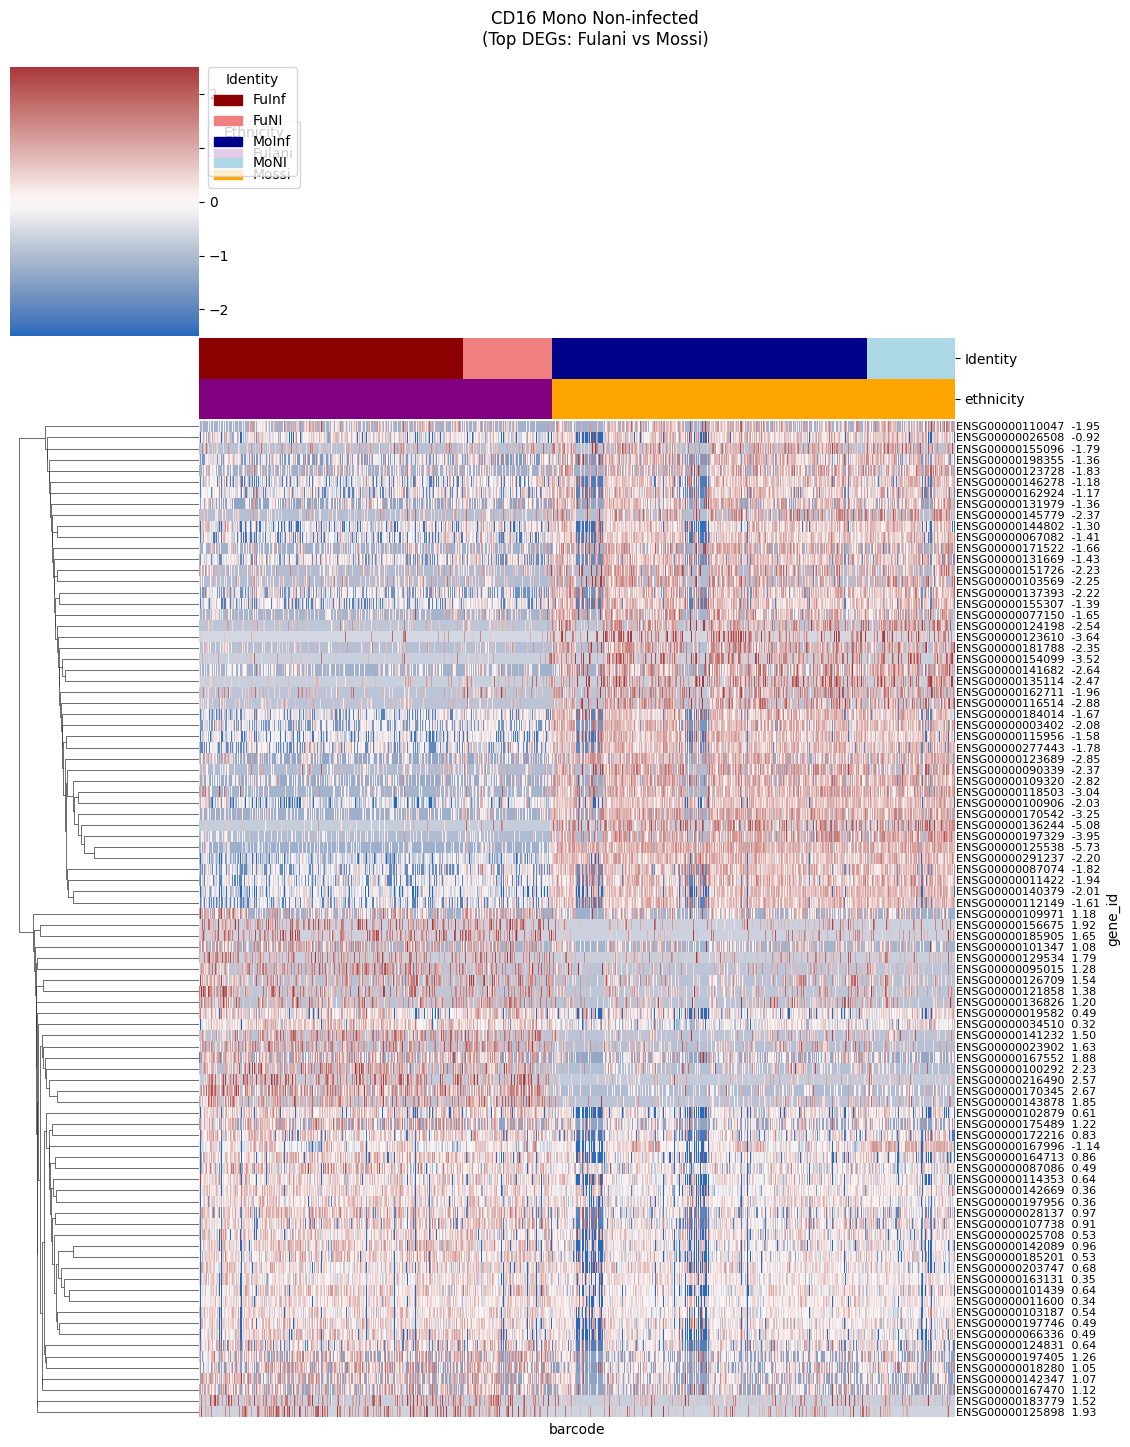


CD16 Mono heatmap generation finished (or skipped).


In [23]:
# === Cell 7 (Corrected): Generate CD16 Mono Heatmap (using Seaborn) ===
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
from adjustText import adjust_text # Ensure adjustText is imported

print("\n--- Generating CD16 Mono Heatmap (using Seaborn Clustermap) ---")

# Check if required variables exist
if 'top_genes_cd16' not in locals() or not top_genes_cd16:
    print("Skipping CD16 Mono heatmap: Gene list ('top_genes_cd16') not found (Run Cell 5).")
elif 'de_results' not in locals() or f'{cell_type_cd16}_{condition_ni}' not in de_results or de_results[f'{cell_type_cd16}_{condition_ni}'] is None:
    print(f"Skipping CD16 Mono heatmap: DE results for '{cell_type_cd16}_{condition_ni}' not found (Run Cell 2 - Scanpy DE).")
else:
    # Get the relevant DE results for LFC values
    de_cd16_ni = de_results[f'{cell_type_cd16}_{condition_ni}']

    # 1. Subset AnnData
    adata_sub = adata[adata.obs[cell_subtype_key] == cell_type_cd16, top_genes_cd16].copy()
    print(f"Subsetted data for CD16 Mono heatmap: {adata_sub.shape}")

    if adata_sub.n_obs == 0 or adata_sub.n_vars == 0 :
        print("Skipping CD16 Mono heatmap: Subset resulted in zero cells or genes.")
    else:
        # 2. Scale data
        sc.pp.scale(adata_sub, max_value=10)
        print("Data scaled.")

        # 3. Get data into pandas DataFrame (Genes x Cells)
        plot_df = pd.DataFrame(adata_sub.X, index=adata_sub.obs_names, columns=adata_sub.var_names).T # Genes as index, Cells as columns

        # 4. Prepare Column Metadata and Colors
        col_meta_sorted = adata_sub.obs.sort_values(by=['Identity', ethnicity_key])
        plot_df_sorted = plot_df[col_meta_sorted.index] # Reorder columns (cells)

        identity_palette = {'FuInf':'darkred', 'FuNI':'lightcoral', 'MoInf':'darkblue', 'MoNI':'lightblue'}
        ethnicity_palette = {'Fulani': 'purple', 'Mossi': 'orange'}

        col_colors_mapped = col_meta_sorted[['Identity', ethnicity_key]].copy()
        col_colors_mapped['Identity'] = col_meta_sorted['Identity'].map(identity_palette)
        col_colors_mapped[ethnicity_key] = col_meta_sorted[ethnicity_key].map(ethnicity_palette)
        print("Prepared column colors.")

        # 5. Plot using seaborn.clustermap
        print("Generating clustermap...")
        try:
            g = sns.clustermap(
                plot_df_sorted, # Genes as rows, sorted Cells as columns
                row_cluster=True,
                col_cluster=False,
                col_colors=col_colors_mapped,
                standard_scale=None,
                cmap='vlag',
                vmin=-2.5, vmax=2.5,
                linewidths=0,
                figsize=(12, 14),
                xticklabels=False,
                yticklabels=True # Show Y tick labels (will be replaced)
            )

            # --- Add Custom Gene + LFC Labels ---
            ordered_gene_indices = g.dendrogram_row.reordered_ind
            ordered_gene_names = plot_df_sorted.index[ordered_gene_indices]
            custom_labels = []
            for gene in ordered_gene_names:
                if gene in de_cd16_ni.index:
                    lfc = de_cd16_ni.loc[gene, 'log2FoldChange']
                    lfc_str = f"{lfc:.2f}" if not np.isnan(lfc) else "N/A"
                    custom_labels.append(f"{gene}  {lfc_str}")
                else:
                    custom_labels.append(f"{gene}  N/A")

            g.ax_heatmap.set_yticklabels(custom_labels, rotation=0, ha='left', fontsize=8)
            g.ax_heatmap.tick_params(axis='y', pad=0.5, length=0)

            # --- Final Touches ---
            handles_id = [plt.Rectangle((0,0),1,1, color=identity_palette[label]) for label in identity_palette]
            leg1 = plt.legend(handles_id, identity_palette.keys(), title='Identity', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            handles_eth = [plt.Rectangle((0,0),1,1, color=ethnicity_palette[label]) for label in ethnicity_palette]
            leg2 = plt.legend(handles_eth, ethnicity_palette.keys(), title='Ethnicity', bbox_to_anchor=(1.05, 0.8), loc='upper left', borderaxespad=0.)
            g.fig.add_artist(leg1)

            plt.suptitle(f"{cell_type_cd16} Non-infected\n(Top DEGs: {group1_ethnicity} vs {group2_ethnicity})", y=1.03)
            g.fig.subplots_adjust(right=0.8)
            plt.show()

        except Exception as e:
              print(f"Error during seaborn.clustermap or labeling: {e}")
              import traceback
              traceback.print_exc()

print("\nCD16 Mono heatmap generation finished (or skipped).")

In [24]:
# === Add this to Cell 8 (or a new cell before it) ===
import pandas as pd

# 1. Load your CSV file
csv_path = '/content/drive/MyDrive/cluster_markers_aligned_all.csv' # <<< Make sure this path is correct
try:
    marker_df = pd.read_csv(csv_path)
    print(f"Loaded CSV file: {csv_path}")
except FileNotFoundError:
    raise FileNotFoundError(f"CSV file not found at: {csv_path}. Please check the path.")

# 2. Create the mapping dictionary (Symbol -> Ensembl ID)
# Assuming columns are named 'gene_symbol' and 'gene_id' (adjust if different, e.g., 'names')
if 'gene_symbol' in marker_df.columns and 'gene_id' in marker_df.columns:
    # Drop duplicates based on gene symbol, keeping the first occurrence
    marker_df_unique = marker_df.drop_duplicates(subset=['gene_symbol'])
    symbol_to_ensembl = pd.Series(marker_df_unique.gene_id.values, index=marker_df_unique.gene_symbol).to_dict()
    print(f"Created mapping dictionary for {len(symbol_to_ensembl)} unique gene symbols.")
elif 'names' in marker_df.columns and 'gene_id' in marker_df.columns:
     # Fallback if 'gene_symbol' column doesn't exist but 'names' does
     marker_df_unique = marker_df.drop_duplicates(subset=['names'])
     symbol_to_ensembl = pd.Series(marker_df_unique.gene_id.values, index=marker_df_unique.names).to_dict()
     print(f"Created mapping dictionary using 'names' column for {len(symbol_to_ensembl)} unique gene symbols.")
else:
    raise KeyError("Required columns ('gene_symbol'/'names' and 'gene_id') not found in CSV.")

# Now you can use this dictionary to translate the paper's gene list

# 3. Example: Translate a list of symbols from the paper
paper_gene_symbols = ['TNF', 'IL6', 'IFIT1', 'HLA-A', 'NonExistentGene'] # EXAMPLE LIST - REPLACE
ensembl_ids_for_plot = []
genes_not_found = []
for symbol in paper_gene_symbols:
    ensembl_id = symbol_to_ensembl.get(symbol) # Use .get() to handle missing symbols gracefully
    if ensembl_id:
        ensembl_ids_for_plot.append(ensembl_id)
    else:
        genes_not_found.append(symbol)

print(f"\nExample Translation:")
print(f"  Input Symbols: {paper_gene_symbols}")
print(f"  Translated Ensembl IDs: {ensembl_ids_for_plot}")
if genes_not_found:
    print(f"  Warning: Symbols not found in CSV mapping: {genes_not_found}")

# 4. Now EDIT Cell 8's genes_by_pathway dictionary using the actual pathways
#    from the paper and the translated Ensembl IDs.
# Example:
# genes_by_pathway = {
#    'TNF': [symbol_to_ensembl.get('TNF')], # Get Ensembl ID for TNF
#    'Interferon TypeI/II': [symbol_to_ensembl.get('IFIT1'), symbol_to_ensembl.get('IFIT3'), ...],
#    # ... etc. for all pathways and translated genes from the paper ...
# }
# Remember to handle cases where a gene symbol from the paper might be missing in your CSV map.

Loaded CSV file: /content/drive/MyDrive/cluster_markers_aligned_all.csv
Created mapping dictionary for 1506 unique gene symbols.

Example Translation:
  Input Symbols: ['TNF', 'IL6', 'IFIT1', 'HLA-A', 'NonExistentGene']
  Translated Ensembl IDs: ['ENSG00000232810', 'ENSG00000136244', 'ENSG00000185745']


In [25]:
# === Cell 8 (Revised): Define Gene List and Pathways based on Figure S6D ===

import pandas as pd # Make sure pandas is imported if running this cell standalone

# Prerequisites: The 'symbol_to_ensembl' dictionary should exist from loading your CSV.
if 'symbol_to_ensembl' not in locals():
    raise NameError("The 'symbol_to_ensembl' dictionary mapping is missing. Please run the CSV loading cell first.")

print("--- Defining Gene Lists for Dot Plot based on Figure S6D ---")

# Define pathways and gene symbols exactly as shown in the figure
genes_by_pathway_symbols = {
    'Antigen presentation': [
        'TSPOAP1', 'CD74', 'HLA-DRA', 'HLA-DRB1', 'HLA-DRB5', 'HLA-DQA1',
        'HLA-DQB1', 'HLA-DPA1', 'HLA-DPB1', 'HLA-A', 'HLA-B', 'HLA-C',
        'HLA-E', 'HLA-F', 'B2M', 'TAP1', 'PSMB9' # Note: Paper image has PSMB9, placeholder had PSMB8/9
    ],
    'Phagocytosis': [
        'FCAR', 'FCGR1A', 'FCGR2A', 'FCGR2B', 'FCGR3A', 'MSR1', 'CD68',
        'CD36', 'LYZ' # Note: Paper image missing CTSB/CTSS from example
    ],
    'Cytokine/Chemokine': [
        'S100A8', 'S100A9', 'S100A12', 'IL1B', 'IL18', 'IL10', 'IL1RN',
        'CXCL8', 'CXCL10', 'CXCL11', 'CXCL16', 'CCL3', 'CCL3L1', 'CCL4',
        'CCL4L2', 'CCL5', 'CCRL2' # Note: Paper image missing IL6, IL12, IL15, IL23, TNF from example list here
    ],
    'Inflammatory response': [
        'CAMP', 'HP', 'TLR2', 'TLR4', 'CASP1', 'TNFAIP3', 'TNFAIP6', # Note: TNFAIP6 added
        'NFKBIA', 'NFKBIE', 'PTGES2' # Note: Paper image missing LTF, DEFB1, CLEC4E from example
    ],
    'TNF': [
        'TNF', 'LTA'
        ],
    'Interferon TypeI/II': [
        'IFITM1', 'IFITM2', 'IFITM3', 'IFIT1', 'IFIT3', 'ISG15', 'OAS1', # Note: Paper image missing ISG20, OAS2/3, MX's from example
        'OASL', 'GBP1', 'GBP2', 'GBP3', 'GBP4', 'GBP5', 'STAT1', 'STAT2',
        'IRF1', 'IRF7', 'IRF9'
    ],
    'NFKB/AP1/JAK-STAT': [
        'NFKB1', 'NFKB2', 'RELA', 'RELB', 'NFKBIA', 'NFKBIE', 'FOS', 'JUN', # Note: Paper image missing JUND, JAKs, STAT3/4/5/6 from example
        'JUNB', 'STAT1', 'STAT2', 'DUSP1', 'SOCS1', 'SOCS3'
    ]
}

# --- Translate Symbols to Ensembl IDs using the mapping dictionary ---
print("Translating gene symbols to Ensembl IDs...")
genes_by_pathway = {} # This will hold the Ensembl IDs
genes_found_map = {}
genes_not_found_map = {}

for pathway, symbols in genes_by_pathway_symbols.items():
    ensembl_ids = []
    found_symbols = []
    missing_symbols = []
    for symbol in symbols:
        ensembl_id = symbol_to_ensembl.get(symbol)
        if ensembl_id:
            ensembl_ids.append(ensembl_id)
            found_symbols.append(symbol)
        else:
            missing_symbols.append(symbol)
    if ensembl_ids:
        genes_by_pathway[pathway] = ensembl_ids
    genes_found_map[pathway] = found_symbols
    genes_not_found_map[pathway] = missing_symbols
    if missing_symbols:
         print(f"  Warning: Symbols not found in mapping for pathway '{pathway}': {missing_symbols}")


# --- Clean up the lists: Remove genes not present in adata.var_names ---
print("\nChecking gene availability in adata...")
available_genes_by_pathway = {}
all_genes_to_plot = []
total_genes_defined_translated = 0
total_genes_found_in_adata = 0

for pathway, ensembl_ids in genes_by_pathway.items():
    # Filter out genes that might be in the map but not in adata.var_names
    available_genes = [gene_id for gene_id in ensembl_ids if gene_id in adata.var_names]

    defined_count = len(ensembl_ids) # How many were successfully translated
    found_count = len(available_genes)
    total_genes_defined_translated += defined_count
    total_genes_found_in_adata += found_count

    if available_genes:
        available_genes_by_pathway[pathway] = available_genes
        all_genes_to_plot.extend(available_genes)
        print(f"  Pathway '{pathway}': Kept {found_count} out of {defined_count} translated Ensembl IDs.")
        if found_count < defined_count:
             # Find which translated IDs were missing from adata
             missing_in_adata_ids = [eid for eid in ensembl_ids if eid not in available_genes]
             # Try to find the original symbols for these missing IDs
             symbols_missing_in_adata = [symbol for symbol, ensg in symbol_to_ensembl.items() if ensg in missing_in_adata_ids]
             print(f"    (Note: {defined_count - found_count} Ensembl IDs were not present in adata.var_names. Original symbols might include: {symbols_missing_in_adata})")

    else:
        # This case means symbols were translated, but *none* of the Ensembl IDs were in adata
        print(f"  Pathway '{pathway}': Found 0 available genes in adata out of {defined_count} translated Ensembl IDs.")
        original_symbols = genes_found_map.get(pathway, [])
        if original_symbols:
            print(f"     (Original symbols for this pathway were: {original_symbols})")


print(f"\nTotal unique genes available for plotting across all pathways: {len(set(all_genes_to_plot))} (out of {total_genes_defined_translated} successfully translated Ensembl IDs)")

# Ensure we have genes to plot
if not all_genes_to_plot:
     raise ValueError("No genes from the defined list were found/available in adata.var_names after translation. Please check the gene lists, the symbol->Ensembl mapping, and adata.var_names.")
else:
     print("Gene list successfully prepared with Ensembl IDs.")

--- Defining Gene Lists for Dot Plot based on Figure S6D ---
Translating gene symbols to Ensembl IDs...

Checking gene availability in adata...
  Pathway 'Antigen presentation': Kept 5 out of 7 translated Ensembl IDs.
    (Note: 2 Ensembl IDs were not present in adata.var_names. Original symbols might include: ['HLA-DRA', 'HLA-DPA1'])
  Pathway 'Phagocytosis': Kept 6 out of 7 translated Ensembl IDs.
    (Note: 1 Ensembl IDs were not present in adata.var_names. Original symbols might include: ['FCAR'])
  Pathway 'Cytokine/Chemokine': Kept 13 out of 15 translated Ensembl IDs.
    (Note: 2 Ensembl IDs were not present in adata.var_names. Original symbols might include: ['CCL4L2', 'CCL3'])
  Pathway 'Inflammatory response': Kept 3 out of 3 translated Ensembl IDs.
  Pathway 'TNF': Kept 1 out of 1 translated Ensembl IDs.
  Pathway 'Interferon TypeI/II': Kept 9 out of 10 translated Ensembl IDs.
    (Note: 1 Ensembl IDs were not present in adata.var_names. Original symbols might include: ['IRF


--- Generating Dot Plot ---
Creating/Re-creating combined group column: 'celltype_identity'

Intended category order: ['CD14 Mono_MoNI', 'CD14 Mono_MoInf', 'CD14 Mono_FuNI', 'CD14 Mono_FuInf', 'CD16 Mono_MoNI', 'CD16 Mono_MoInf', 'CD16 Mono_FuNI', 'CD16 Mono_FuInf']
Setting categories using full defined order...

--- Checking raw metadata for FulInf groups in subset ---
Number of FulInf cells in subset: 14720
Unique 'Identity' values for FulInf cells: ['FuInf']
Unique 'cell_subtype' values for FulInf cells: ['CD16 Mono', 'CD14 Mono']
---------------------------------------------------------
Final categories set in AnnData for plotting: ['CD14 Mono_MoNI', 'CD14 Mono_MoInf', 'CD14 Mono_FuNI', 'CD14 Mono_FuInf', 'CD16 Mono_MoNI', 'CD16 Mono_MoInf', 'CD16 Mono_FuNI', 'CD16 Mono_FuInf']

Generating Dot Plot with visual adjustments...


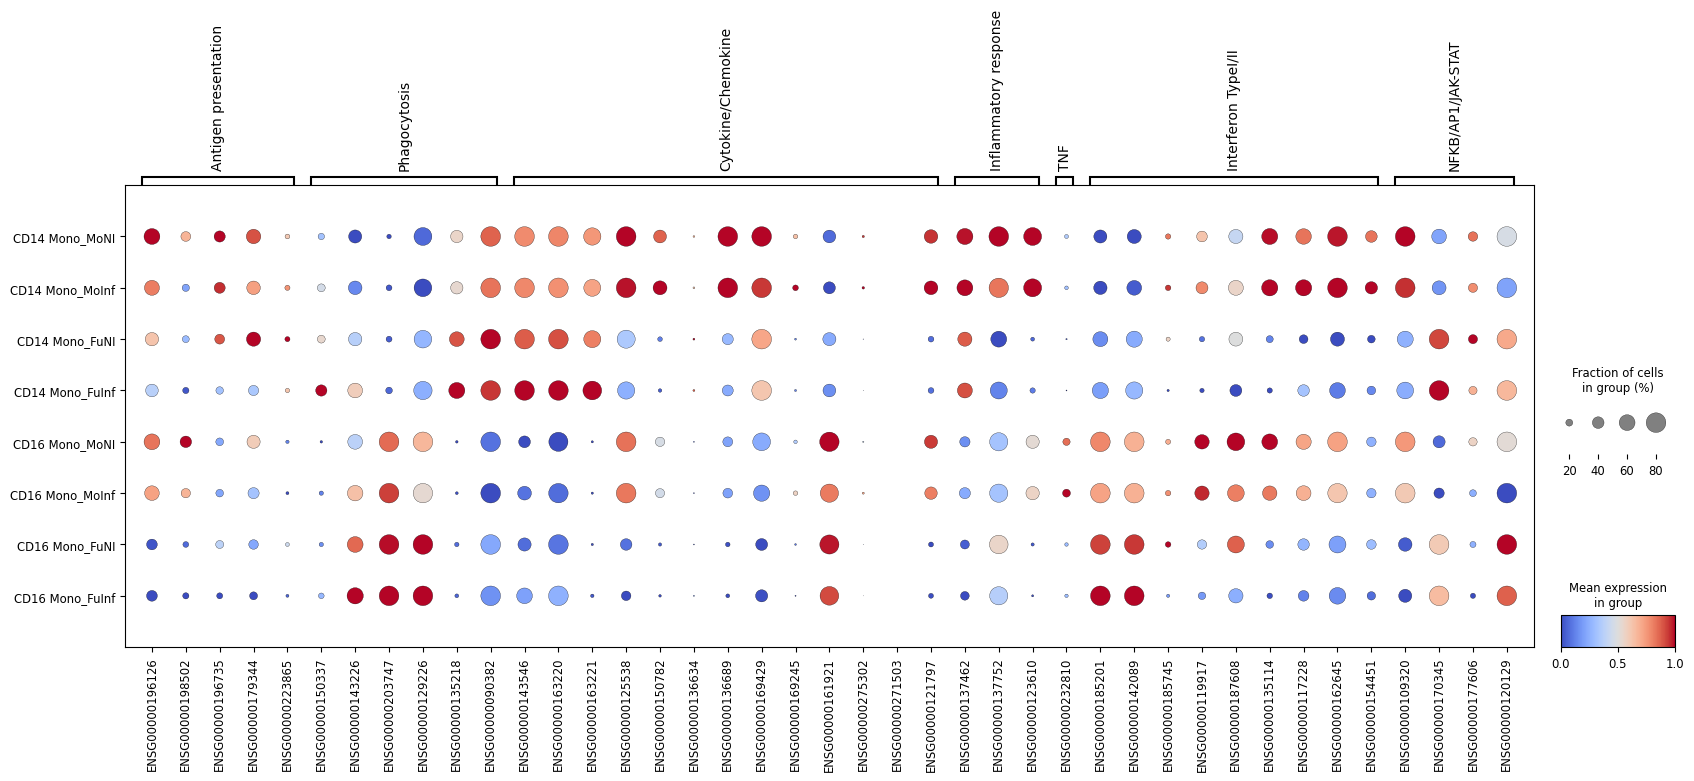


Dot plot generation finished.


In [45]:
# === Cell 9 (Final Attempt): Prepare Grouping and Generate Dot Plot ===
import pandas as pd # Ensure pandas is imported
import scanpy as sc
import numpy as np # Ensure numpy is imported
import matplotlib.pyplot as plt # Ensure pyplot is imported

print("\n--- Generating Dot Plot ---")

# 1. Subset data first
adata_dotplot = adata[adata.obs[cell_subtype_key].isin([cell_type_cd14, cell_type_cd16])].copy()

# 2. Create/Re-create combined group identifier with stripping whitespace
dotplot_group_key = 'celltype_identity'
print(f"Creating/Re-creating combined group column: '{dotplot_group_key}'")
adata_dotplot.obs[dotplot_group_key] = (
    adata_dotplot.obs[cell_subtype_key].astype(str).str.strip() + # Add strip()
    '_' +
    adata_dotplot.obs['Identity'].astype(str).str.strip() # Add strip()
)

# --- Filter out cells with NaN combined group key ---
original_cell_count = adata_dotplot.n_obs
adata_dotplot = adata_dotplot[~adata_dotplot.obs[dotplot_group_key].isna()].copy()
nan_filtered_count = original_cell_count - adata_dotplot.n_obs
if nan_filtered_count > 0:
    print(f"Filtered out {nan_filtered_count} cells with NaN combined group key.")
# -------------------------------------------------

# --- Define the full, intended order of groups ---
group_order = [
    f'{cell_type_cd14}_MoNI', f'{cell_type_cd14}_MoInf', f'{cell_type_cd14}_FuNI', f'{cell_type_cd14}_FuInf',
    f'{cell_type_cd16}_MoNI', f'{cell_type_cd16}_MoInf', f'{cell_type_cd16}_FuNI', f'{cell_type_cd16}_FuInf'
]
print(f"\nIntended category order: {group_order}")

# --- Set categorical using the full intended order ---
print(f"Setting categories using full defined order...")
adata_dotplot.obs[dotplot_group_key] = pd.Categorical(
    adata_dotplot.obs[dotplot_group_key],
    categories=group_order, # <<< USE THE FULL group_order HERE
    ordered=True
)

print("\n--- Checking raw metadata for FulInf groups in subset ---")
fulinf_cells = adata_dotplot.obs['Identity'] == 'FuInf'
print(f"Number of FulInf cells in subset: {fulinf_cells.sum()}")
if fulinf_cells.sum() > 0:
    print("Unique 'Identity' values for FulInf cells:", adata_dotplot.obs.loc[fulinf_cells, 'Identity'].unique().tolist())
    print(f"Unique '{cell_subtype_key}' values for FulInf cells:", adata_dotplot.obs.loc[fulinf_cells, cell_subtype_key].unique().tolist())
print("---------------------------------------------------------")

# --- REMOVED THIS LINE ---
# adata_dotplot.obs[dotplot_group_key] = adata_dotplot.obs[dotplot_group_key].cat.remove_unused_categories()
# -------------------------

# Check final categories before plotting
print(f"Final categories set in AnnData for plotting: {adata_dotplot.obs[dotplot_group_key].cat.categories.tolist()}")


# 5. Plot using scanpy.pl.dotplot
print("\nGenerating Dot Plot with visual adjustments...")
try:
    # Check if available_genes_by_pathway exists from Cell 8
    if 'available_genes_by_pathway' not in locals():
         raise NameError("'available_genes_by_pathway' not defined. Run Cell 8 first.")

    sc.pl.dotplot(
        adata_dotplot,
        var_names=available_genes_by_pathway, # From Cell 8
        groupby=dotplot_group_key,
        standard_scale='var',
        use_raw=False,
        cmap='coolwarm', # Blue-White-Red colormap
        figsize=(20, 6),
        dot_max=0.8,
        dot_min=0,
        # vmin=-1.5, vmax=1.5,
        show=True
    )
except Exception as e:
     print(f"\nError during dotplot generation: {e}")
     import traceback
     traceback.print_exc()


print("\nDot plot generation finished.")

In [42]:
print("Cross-tabulation of Cell Subtype vs Identity:")
print(pd.crosstab(adata.obs[cell_subtype_key], adata.obs['Identity']))

Cross-tabulation of Cell Subtype vs Identity:
Identity           FuInf  FuNI  MoInf  MoNI
cell_subtype                               
ASDC                   0     2     14     2
B intermediate      5930  3670   8519  2795
B memory            2730  1386   2954  1052
B naive             5622  3720   5698  2858
CD4 CTL              176   156    160   172
CD4 Naive          13094  6469  13541  5476
CD4 Proliferating     42    12     48    26
CD4 TCM            11904  7046  15061  6162
CD4 TEM             1166   951   1648   634
CD8 Naive           5859  2969   6277  2122
CD8 Proliferating     42    24      4     4
CD8 TCM              150   138     94   108
CD8 TEM             6630  4396   7753  3138
CD14 Mono           7789  3881   5456  2694
CD16 Mono           6931  2338   8292  2318
Doublet               38    10      8     0
Eryth               1847   576   1369   405
HSPC                  34    52     51    28
ILC                   62    32     50    32
MAIT                 363   496

In [139]:
print("Counts per group in the main 'adata' object:")
# Use fill_value=0 to show groups with zero cells
print(adata.obs.groupby([cell_subtype_key, 'Identity']).size().unstack(fill_value=0))

Counts per group in the main 'adata' object:
Identity           FuInf  FuNI  MoInf  MoNI  nanan
cell_subtype                                      
ASDC                   0     2     14     2      0
B intermediate      5930  3670   8519  2795      0
B memory            2730  1386   2954  1052      0
B naive             5622  3720   5698  2858      0
CD4 CTL              176   156    160   172      0
CD4 Naive          13094  6469  13541  5476      0
CD4 Proliferating     42    12     48    26      0
CD4 TCM            11904  7046  15061  6162      0
CD4 TEM             1166   951   1648   634      0
CD8 Naive           5859  2969   6277  2122      0
CD8 Proliferating     42    24      4     4      0
CD8 TCM              150   138     94   108      0
CD8 TEM             6630  4396   7753  3138      0
CD14 Mono           7789  3881   5456  2694      0
CD16 Mono           6931  2338   8292  2318      0
Doublet               38    10      8     0      0
Eryth               1847   576   1369

<ipython-input-139-cc5280db03e0>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(adata.obs.groupby([cell_subtype_key, 'Identity']).size().unstack(fill_value=0))
